# Rossmann Store Sales Time Series Analysis

1. Perform Analysis of the data related to this competition
2. Apply simple Forecasting models and use the same evaluation from the competition.
3. Apply ETS models (not all models explained, the one that you can see is suitable)
4. Apply the Arima model
5. Apply Prophet
6. Apply any machine learning of your choice
7. Choose the best among them and perform future forecasting on the test set and submit on Kaggle and add the score in your notebook sent to me

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose, STL, MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

## Loading the Data

### Understanding the Dataset

- **Store**: a unique Id for each store
- **Sales**: the turnover for any given day (target variable)
- **Customers**: the number of customers on a given day
- **Open**: an indicator for whether the store was open (0 = closed, 1 = open)
- **StateHoliday**: indicates a state holiday (a = public holiday, b = Easter holiday, c = Christmas, 0 = None)
- **SchoolHoliday**: indicates if the store was affected by the closure of public schools
- **StoreType**: differentiates between 4 different store models: a, b, c, d
- **Assortment**: describes an assortment level: a = basic, b = extra, c = extended
- **CompetitionDistance**: distance in meters to the nearest competitor store
- **CompetitionOpenSince[Month/Year]**: gives the approximate year and month of the time the nearest competitor was opened
- **Promo**: indicates whether a store is running a promo on that day
- **Promo2**: a continuing and consecutive promotion for some stores (0 = store is not participating, 1 = store is participating)
- **Promo2Since[Year/Week]**: describes the year and calendar week when the store started participating in Promo2
- **PromoInterval**: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew

In [2]:
train = pd.read_csv('data/train.csv', parse_dates=['Date'])
store = pd.read_csv('data/store.csv')
test = pd.read_csv('data/test.csv', parse_dates=['Date'])

In [3]:
print("Train shape:", train.shape)
train.head()

Train shape: (1017209, 9)


Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      2          5 2015-07-31   6064        625     1      1            0   
2      3          5 2015-07-31   8314        821     1      1            0   
3      4          5 2015-07-31  13995       1498     1      1            0   
4      5          5 2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [4]:
print("Store shape:", store.shape)  
store.head()

Store shape: (1115, 10)


Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

In [5]:
print("Test shape:", test.shape)
test.head()

Test shape: (41088, 8)


Id  Store  DayOfWeek       Date  Open  Promo StateHoliday  SchoolHoliday
0   1      1          4 2015-09-17   1.0      1            0              0
1   2      3          4 2015-09-17   1.0      1            0              0
2   3      7          4 2015-09-17   1.0      1            0              0
3   4      8          4 2015-09-17   1.0      1            0              0
4   5      9          4 2015-09-17   1.0      1            0              0

## Merge Train and Store

In [6]:
train_merged = pd.merge(train, store, on='Store', how='left')
print("Merged Train shape:", train_merged.shape)
train_merged.head()

Merged Train shape: (1017209, 18)


Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      2          5 2015-07-31   6064        625     1      1            0   
2      3          5 2015-07-31   8314        821     1      1            0   
3      4          5 2015-07-31  13995       1498     1      1            0   
4      5          5 2015-07-31   4822        559     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         a          a                570.0   
2              1         a          a              14130.0   
3              1         c          c                620.0   
4              1         a          a              29910.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                       11.0                    2007.0       1   
2                       12.0                    2006.0       1   
3                        9.0                    2009.0       0   
4                        4.0                    2015.0       0   

   Promo2SinceWeek  Promo2SinceYear    PromoInterval  
0              NaN              NaN              NaN  
1             13.0           2010.0  Jan,Apr,Jul,Oct  
2             14.0           2011.0  Jan,Apr,Jul,Oct  
3              NaN              NaN              NaN  
4              NaN              NaN              NaN

## Exploratory Data Analysis (EDA)

In [7]:
train_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1014567 no

In [8]:
train_merged.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

In [9]:
train_merged.describe()

Store     DayOfWeek                           Date  \
count  1.017209e+06  1.017209e+06                        1017209   
mean   5.584297e+02  3.998341e+00  2014-04-11 01:30:42.846061824   
min    1.000000e+00  1.000000e+00            2013-01-01 00:00:00   
25%    2.800000e+02  2.000000e+00            2013-08-17 00:00:00   
50%    5.580000e+02  4.000000e+00            2014-04-02 00:00:00   
75%    8.380000e+02  6.000000e+00            2014-12-12 00:00:00   
max    1.115000e+03  7.000000e+00            2015-07-31 00:00:00   
std    3.219087e+02  1.997391e+00                            NaN   

              Sales     Customers          Open         Promo  SchoolHoliday  \
count  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06   1.017209e+06   
mean   5.773819e+03  6.331459e+02  8.301067e-01  3.815145e-01   1.786467e-01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   0.000000e+00   
25%    3.727000e+03  4.050000e+02  1.000000e+00  0.000000e+00   0.000000e+00   
50%    5.744000e+03  6.090000e+02  1.000000e+00  0.000000e+00   0.000000e+00   
75%    7.856000e+03  8.370000e+02  1.000000e+00  1.000000e+00   0.000000e+00   
max    4.155100e+04  7.388000e+03  1.000000e+00  1.000000e+00   1.000000e+00   
std    3.849926e+03  4.644117e+02  3.755392e-01  4.857586e-01   3.830564e-01   

       CompetitionDistance  CompetitionOpenSinceMonth  \
count         1.014567e+06              693861.000000   
mean          5.430086e+03                   7.222866   
min           2.000000e+01                   1.000000   
25%           7.100000e+02                   4.000000   
50%           2.330000e+03                   8.000000   
75%           6.890000e+03                  10.000000   
max           7.586000e+04                  12.000000   
std           7.715324e+03                   3.211832   

       CompetitionOpenSinceYear        Promo2  Promo2SinceWeek  \
count             693861.000000  1.017209e+06    509178.000000   
mean                2008.690228  5.005638e-01        23.269093   
min                 1900.000000  0.000000e+00         1.000000   
25%                 2006.000000  0.000000e+00        13.000000   
50%                 2010.000000  1.000000e+00        22.000000   
75%                 2013.000000  1.000000e+00        37.000000   
max                 2015.000000  1.000000e+00        50.000000   
std                    5.992644  4.999999e-01        14.095973   

       Promo2SinceYear  
count    509178.000000  
mean       2011.752774  
min        2009.000000  
25%        2011.000000  
50%        2012.000000  
75%        2013.000000  
max        2015.000000  
std           1.662870

### Exploring Target Variable

#### --> Date

In [10]:
train_merged['Date'].dtype

dtype('<M8[ns]')

In [11]:
train_merged['Date'].isnull().sum()

0

In [12]:
train_merged['Date'].describe()

count                          1017209
mean     2014-04-11 01:30:42.846061824
min                2013-01-01 00:00:00
25%                2013-08-17 00:00:00
50%                2014-04-02 00:00:00
75%                2014-12-12 00:00:00
max                2015-07-31 00:00:00
Name: Date, dtype: object

#### --> Sales

In [13]:
train_merged['Sales'].dtype

dtype('int64')

In [14]:
train_merged['Sales'].isnull().sum()

0

In [15]:
train_merged['Sales'].describe()

count    1.017209e+06
mean     5.773819e+03
std      3.849926e+03
min      0.000000e+00
25%      3.727000e+03
50%      5.744000e+03
75%      7.856000e+03
max      4.155100e+04
Name: Sales, dtype: float64

### Visualization

#### Sales Over Time

In [16]:
daily_sales = train_merged.groupby('Date')['Sales'].sum().reset_index()
daily_sales.set_index('Date', inplace=True)

fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# Daily Sales
daily_sales['Sales'].plot(ax=axs[0, 0])
axs[0, 0].set_title('Daily Sales Over Time')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Total Sales')
axs[0, 0].grid(True)

# Weekly Sales using resample
daily_sales.resample('W')['Sales'].sum().plot(ax=axs[0, 1])
axs[0, 1].set_title('Weekly Sales Over Time')
axs[0, 1].set_xlabel('Week')
axs[0, 1].set_ylabel('Total Sales')
axs[0, 1].grid(True)

# Monthly Sales using resample
daily_sales.resample('M')['Sales'].sum().plot(ax=axs[1, 0])
axs[1, 0].set_title('Monthly Sales Over Time')
axs[1, 0].set_xlabel('Month')
axs[1, 0].set_ylabel('Total Sales')
axs[1, 0].grid(True)

# Yearly Sales using resample
daily_sales.resample('Y')['Sales'].sum().plot(ax=axs[1, 1])
axs[1, 1].set_title('Yearly Sales Over Time')
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('Total Sales')
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

In [17]:
daily_sales['Year'] = daily_sales.index.year
daily_sales['Month'] = daily_sales.index.month
daily_sales['Day'] = daily_sales.index.day
daily_sales['DayOfWeek'] = daily_sales.index.dayofweek
daily_sales['WeekOfYear'] = daily_sales.index.isocalendar().week

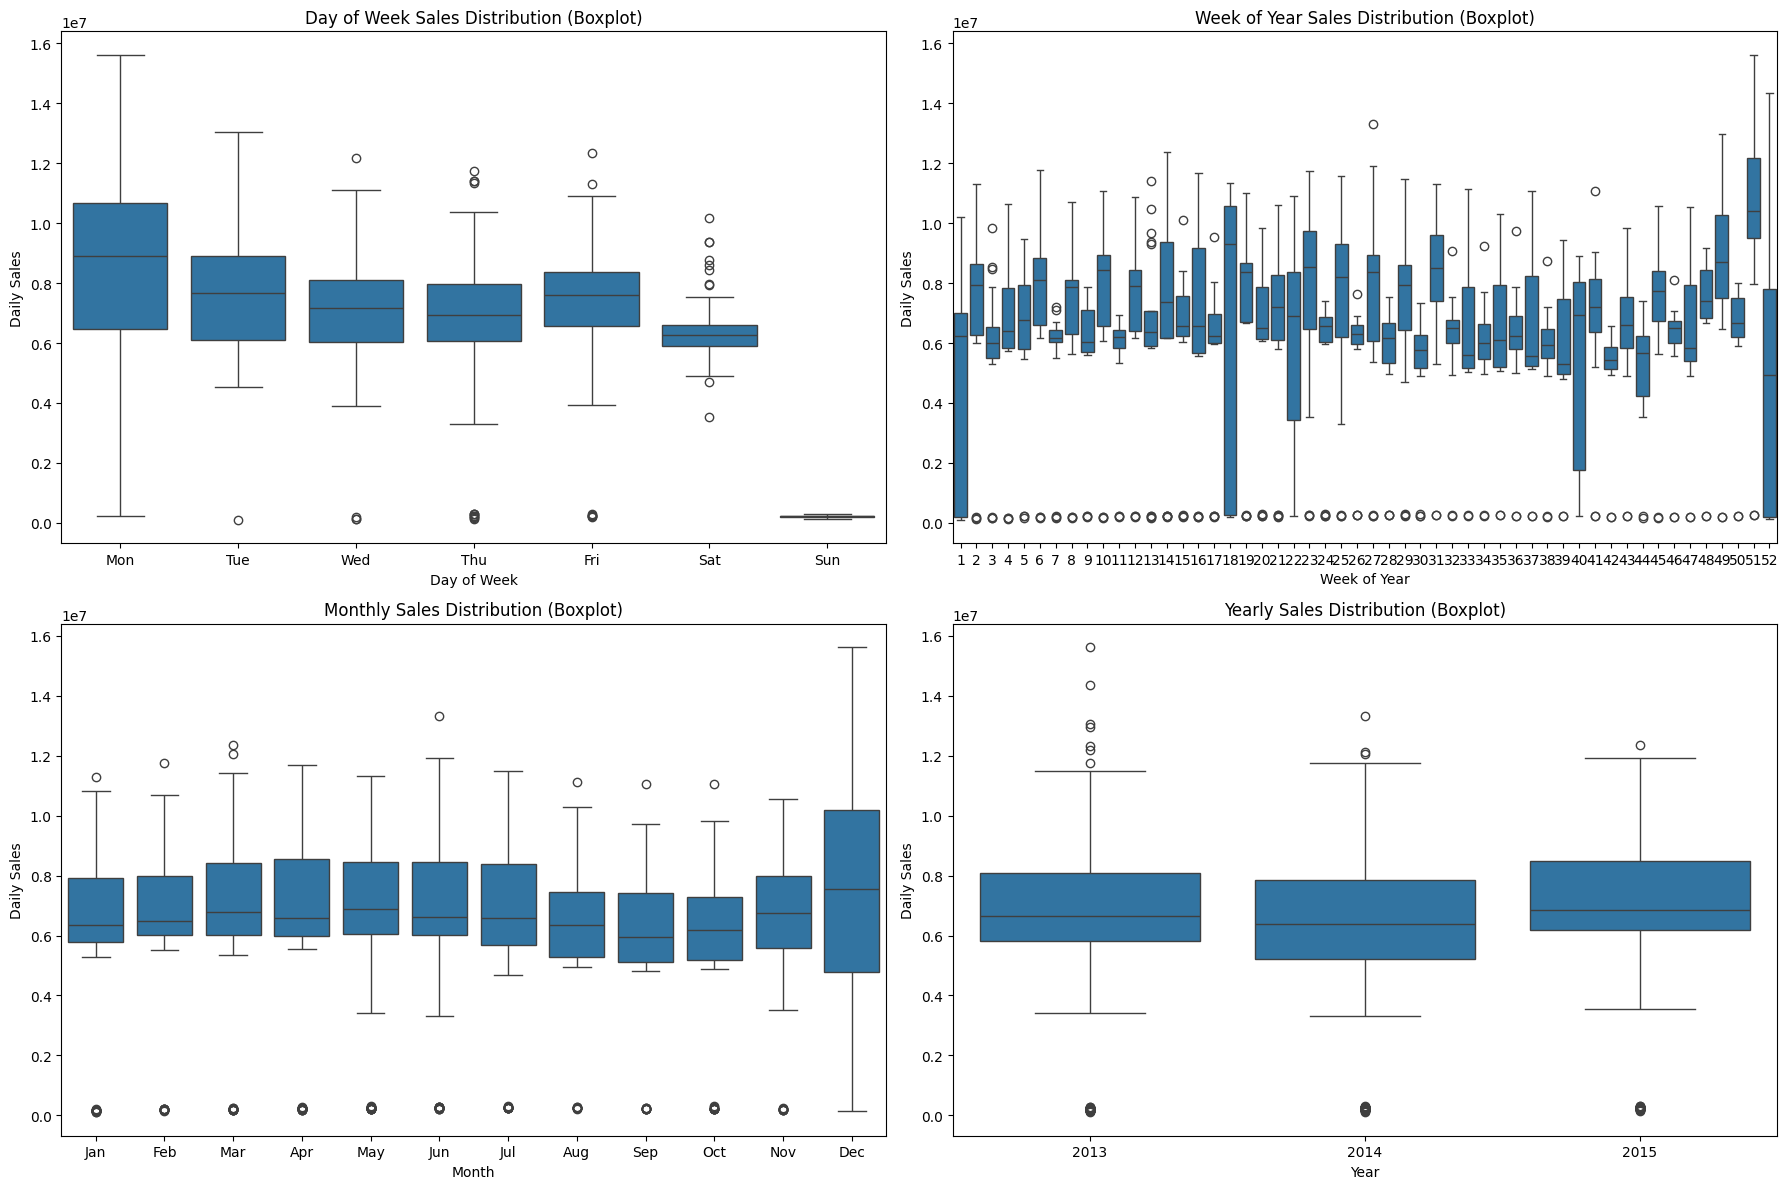

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

# Boxplot by Day of Week
sns.boxplot(x='DayOfWeek', y='Sales', data=daily_sales, ax=axs[0, 0])
axs[0, 0].set_title('Day of Week Sales Distribution (Boxplot)')
axs[0, 0].set_xlabel('Day of Week')
axs[0, 0].set_ylabel('Daily Sales')
axs[0, 0].set_xticks(range(7))
axs[0, 0].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Boxplot by Week of Year
sns.boxplot(x='WeekOfYear', y='Sales', data=daily_sales, ax=axs[0, 1])
axs[0, 1].set_title('Week of Year Sales Distribution (Boxplot)')
axs[0, 1].set_xlabel('Week of Year')
axs[0, 1].set_ylabel('Daily Sales')

# Boxplot by Month
sns.boxplot(x='Month', y='Sales', data=daily_sales, ax=axs[1, 0])
axs[1, 0].set_title('Monthly Sales Distribution (Boxplot)')
axs[1, 0].set_xlabel('Month')
axs[1, 0].set_ylabel('Daily Sales')
axs[1, 0].set_xticks(range(12))
axs[1, 0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Boxplot by Year
sns.boxplot(x='Year', y='Sales', data=daily_sales, ax=axs[1, 1])
axs[1, 1].set_title('Yearly Sales Distribution (Boxplot)')
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('Daily Sales')

plt.tight_layout()
plt.show()

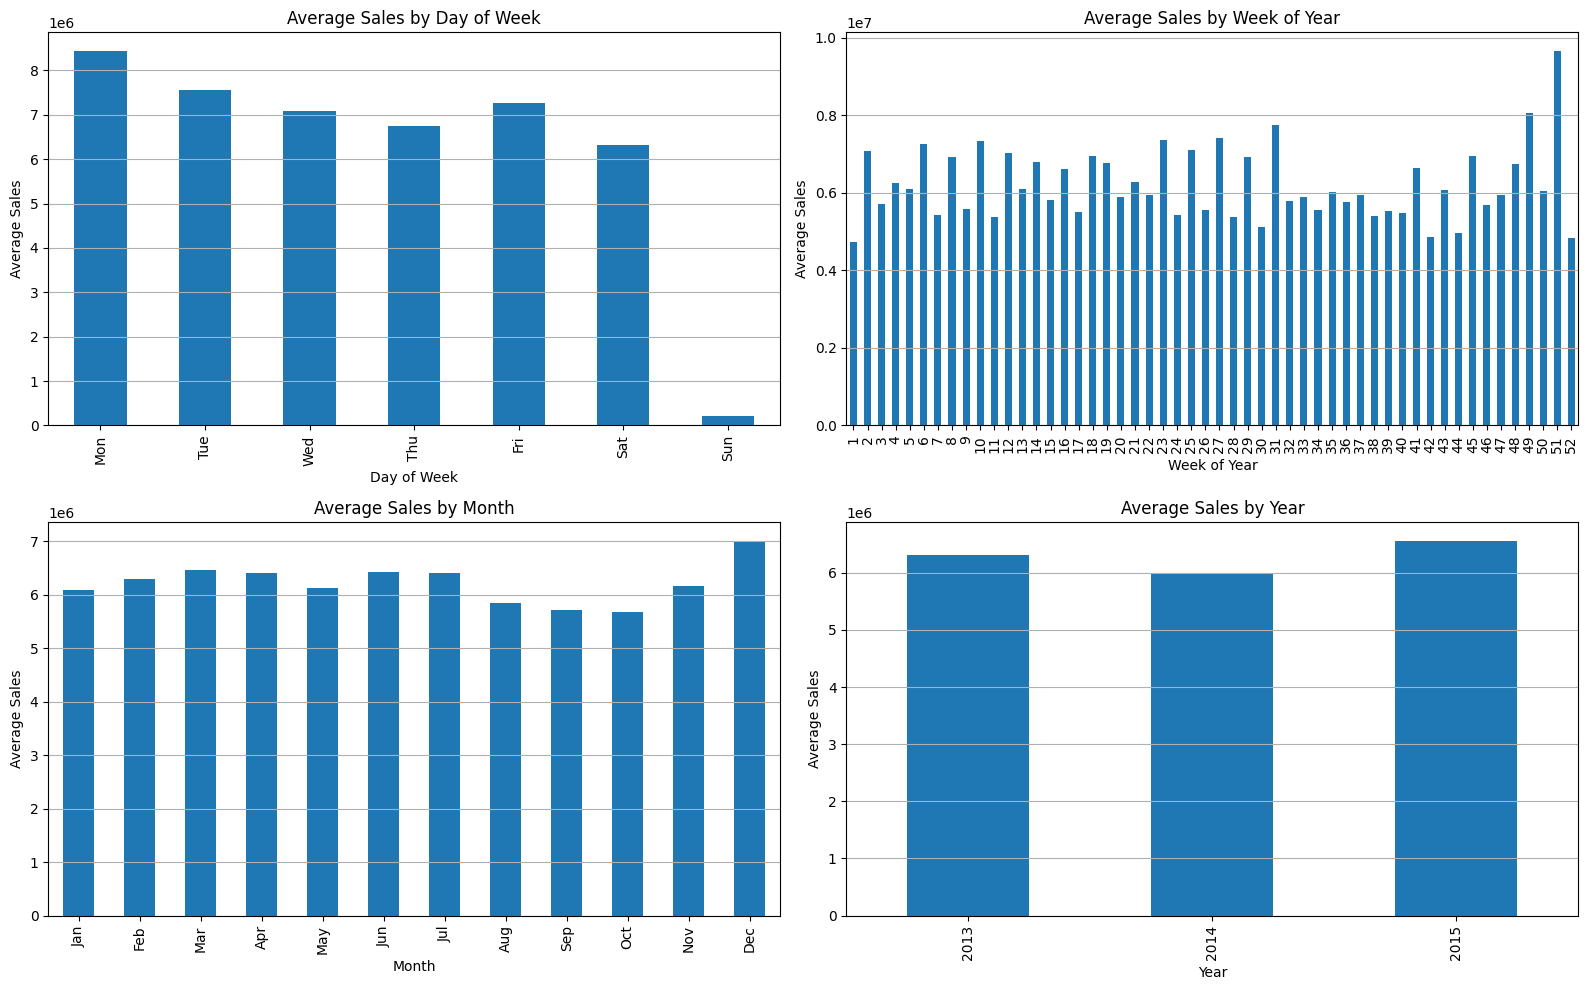

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# Average Sales by Day of Week
daily_sales.groupby('DayOfWeek')['Sales'].mean().plot(kind='bar', ax=axs[0, 0])
axs[0, 0].set_title('Average Sales by Day of Week')
axs[0, 0].set_xlabel('Day of Week')
axs[0, 0].set_ylabel('Average Sales')
axs[0, 0].set_xticks(range(7))
axs[0, 0].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axs[0, 0].grid(True, axis='y')

# Average Sales by Week of Year
daily_sales.groupby('WeekOfYear')['Sales'].mean().plot(kind='bar', ax=axs[0, 1])
axs[0, 1].set_title('Average Sales by Week of Year')
axs[0, 1].set_xlabel('Week of Year')
axs[0, 1].set_ylabel('Average Sales')
axs[0, 1].grid(True, axis='y')

# Average Sales by Month
daily_sales.groupby('Month')['Sales'].mean().plot(kind='bar', ax=axs[1, 0])
axs[1, 0].set_title('Average Sales by Month')
axs[1, 0].set_xlabel('Month')
axs[1, 0].set_ylabel('Average Sales')
axs[1, 0].set_xticks(range(12))
axs[1, 0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axs[1, 0].grid(True, axis='y')

# Average Sales by Year
daily_sales.groupby('Year')['Sales'].mean().plot(kind='bar', ax=axs[1, 1])
axs[1, 1].set_title('Average Sales by Year')
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('Average Sales')
axs[1, 1].grid(True, axis='y')

plt.tight_layout()
plt.show()

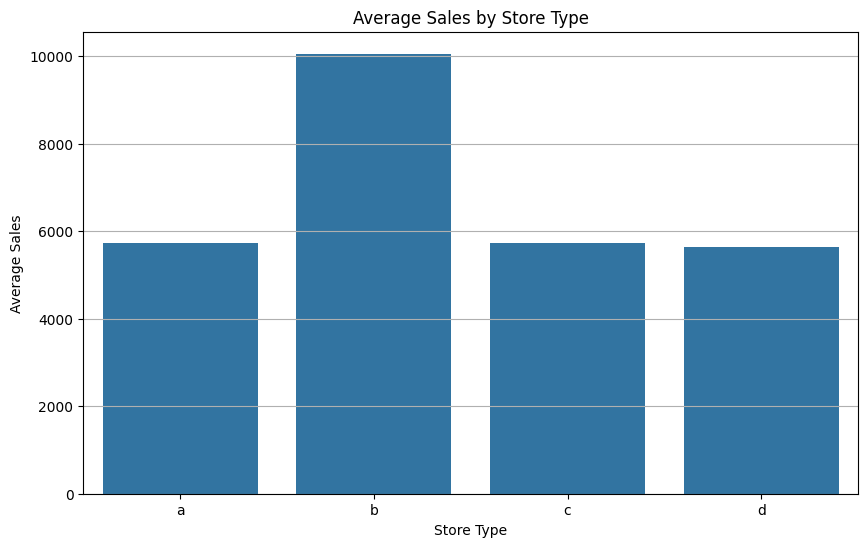

In [20]:
store_type_sales = train_merged.groupby('StoreType')['Sales'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='StoreType', y='Sales', data=store_type_sales)
plt.title('Average Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Average Sales')
plt.grid(True, axis='y')
plt.show()

#### Impact of Promotions and Holidays on Sales

In [21]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Promo', y='Sales', data=train_merged)
plt.title('Sales by Promotion Status')
plt.xlabel('Promotion (0 = No, 1 = Yes)')
plt.ylabel('Sales')
plt.grid(True, axis='y')
plt.show()

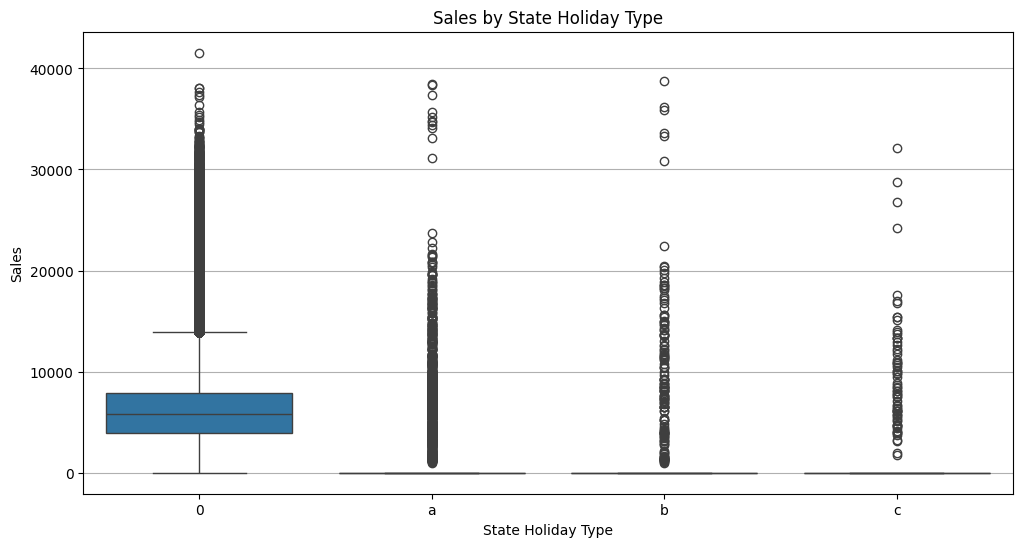

In [22]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='StateHoliday', y='Sales', data=train_merged)
plt.title('Sales by State Holiday Type')
plt.xlabel('State Holiday Type')
plt.ylabel('Sales')
plt.grid(True, axis='y')
plt.show()

In [23]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='SchoolHoliday', y='Sales', data=train_merged)
plt.title('Sales by School Holiday Status')
plt.xlabel('School Holiday (0 = No, 1 = Yes)')
plt.ylabel('Sales')
plt.grid(True, axis='y')
plt.show()

#### Check Stationarity

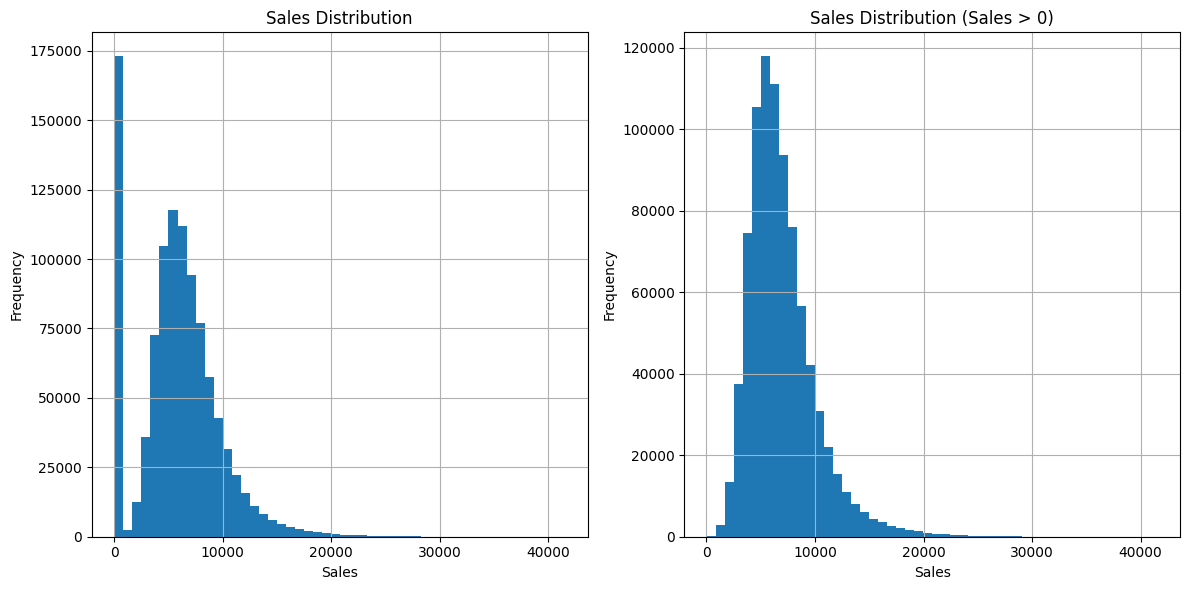

In [24]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
train_merged['Sales'].hist(bins=50)
plt.title('Sales Distribution')
plt.xlabel('Sales')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
train_merged[train_merged['Sales'] > 0]['Sales'].hist(bins=50)
plt.title('Sales Distribution (Sales > 0)')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [25]:
def check_stationarity_stats(series, n_chunks=10):
    chunk_size = len(series) // n_chunks
    means = []
    variances = []
    for i in range(n_chunks):
        chunk = series[i*chunk_size:(i+1)*chunk_size]
        means.append(chunk.mean())
        variances.append(chunk.var())
        print(f"Chunk {i+1}: Mean = {chunk.mean():.2f}, Variance = {chunk.var():.2f}")
    print("\nMeans:", means)
    print("Variances:", variances)


check_stationarity_stats(daily_sales['Sales'])

Chunk 1: Mean = 6099495.00, Variance = 9235687227934.73
Chunk 2: Mean = 6171786.66, Variance = 9762742032885.99
Chunk 3: Mean = 6283197.61, Variance = 8679395441107.19
Chunk 4: Mean = 6701898.99, Variance = 12763241715986.37
Chunk 5: Mean = 6289102.66, Variance = 8763294786013.49
Chunk 6: Mean = 6192407.47, Variance = 11208521154140.45
Chunk 7: Mean = 5336461.13, Variance = 6450808206764.97
Chunk 8: Mean = 6070866.96, Variance = 9748164382824.23
Chunk 9: Mean = 6424961.27, Variance = 10001594636480.43
Chunk 10: Mean = 6709311.91, Variance = 10958927405366.83

Means: [6099495.0, 6171786.659574468, 6283197.606382979, 6701898.989361702, 6289102.659574468, 6192407.468085106, 5336461.127659574, 6070866.957446809, 6424961.265957447, 6709311.914893617]
Variances: [9235687227934.73, 9762742032885.988, 8679395441107.188, 12763241715986.373, 8763294786013.494, 11208521154140.445, 6450808206764.975, 9748164382824.234, 10001594636480.434, 10958927405366.834]


In [26]:
def check_stationarity_tests(series):
    # ADFuller Test
    adf_result = adfuller(series)
    print("ADF Statistic: {:.4f}".format(adf_result[0]))
    print("p-value: {:.4f}".format(adf_result[1]))
    for key, value in adf_result[4].items():
        print('Critical Value ({}): {:.4f}'.format(key, value))
    if adf_result[1] < 0.05:
        print("ADF Test: The series is likely stationary.")
    else:
        print("ADF Test: The series is likely non-stationary.")

    print("\n" + "-"*40 + "\n")

    # KPSS Test
    kpss_result = kpss(series)
    print("KPSS Statistic: {:.4f}".format(kpss_result[0]))
    print("p-value: {:.4f}".format(kpss_result[1]))
    for key, value in kpss_result[3].items():
        print('Critical Value ({}): {:.4f}'.format(key, value))
    if kpss_result[1] < 0.05:
        print("KPSS Test: The series is likely non-stationary.")
    else:
        print("KPSS Test: The series is likely stationary.")


check_stationarity_tests(daily_sales['Sales'])

ADF Statistic: -4.7616
p-value: 0.0001
Critical Value (1%): -3.4375
Critical Value (5%): -2.8647
Critical Value (10%): -2.5684
ADF Test: The series is likely stationary.

----------------------------------------

KPSS Statistic: 0.2051
p-value: 0.1000
Critical Value (10%): 0.3470
Critical Value (5%): 0.4630
Critical Value (2.5%): 0.5740
Critical Value (1%): 0.7390
KPSS Test: The series is likely stationary.


## Time Series Decomposition

In [27]:
store1_data = train_merged[train_merged['Store'] == 1].copy()
store1_daily = store1_data.groupby('Date')['Sales'].sum().reset_index()
store1_daily.set_index('Date', inplace=True)

In [28]:
store1_daily = store1_daily.asfreq('D', fill_value=0)
decomposition = seasonal_decompose(store1_daily['Sales'], model='additive', period=7)

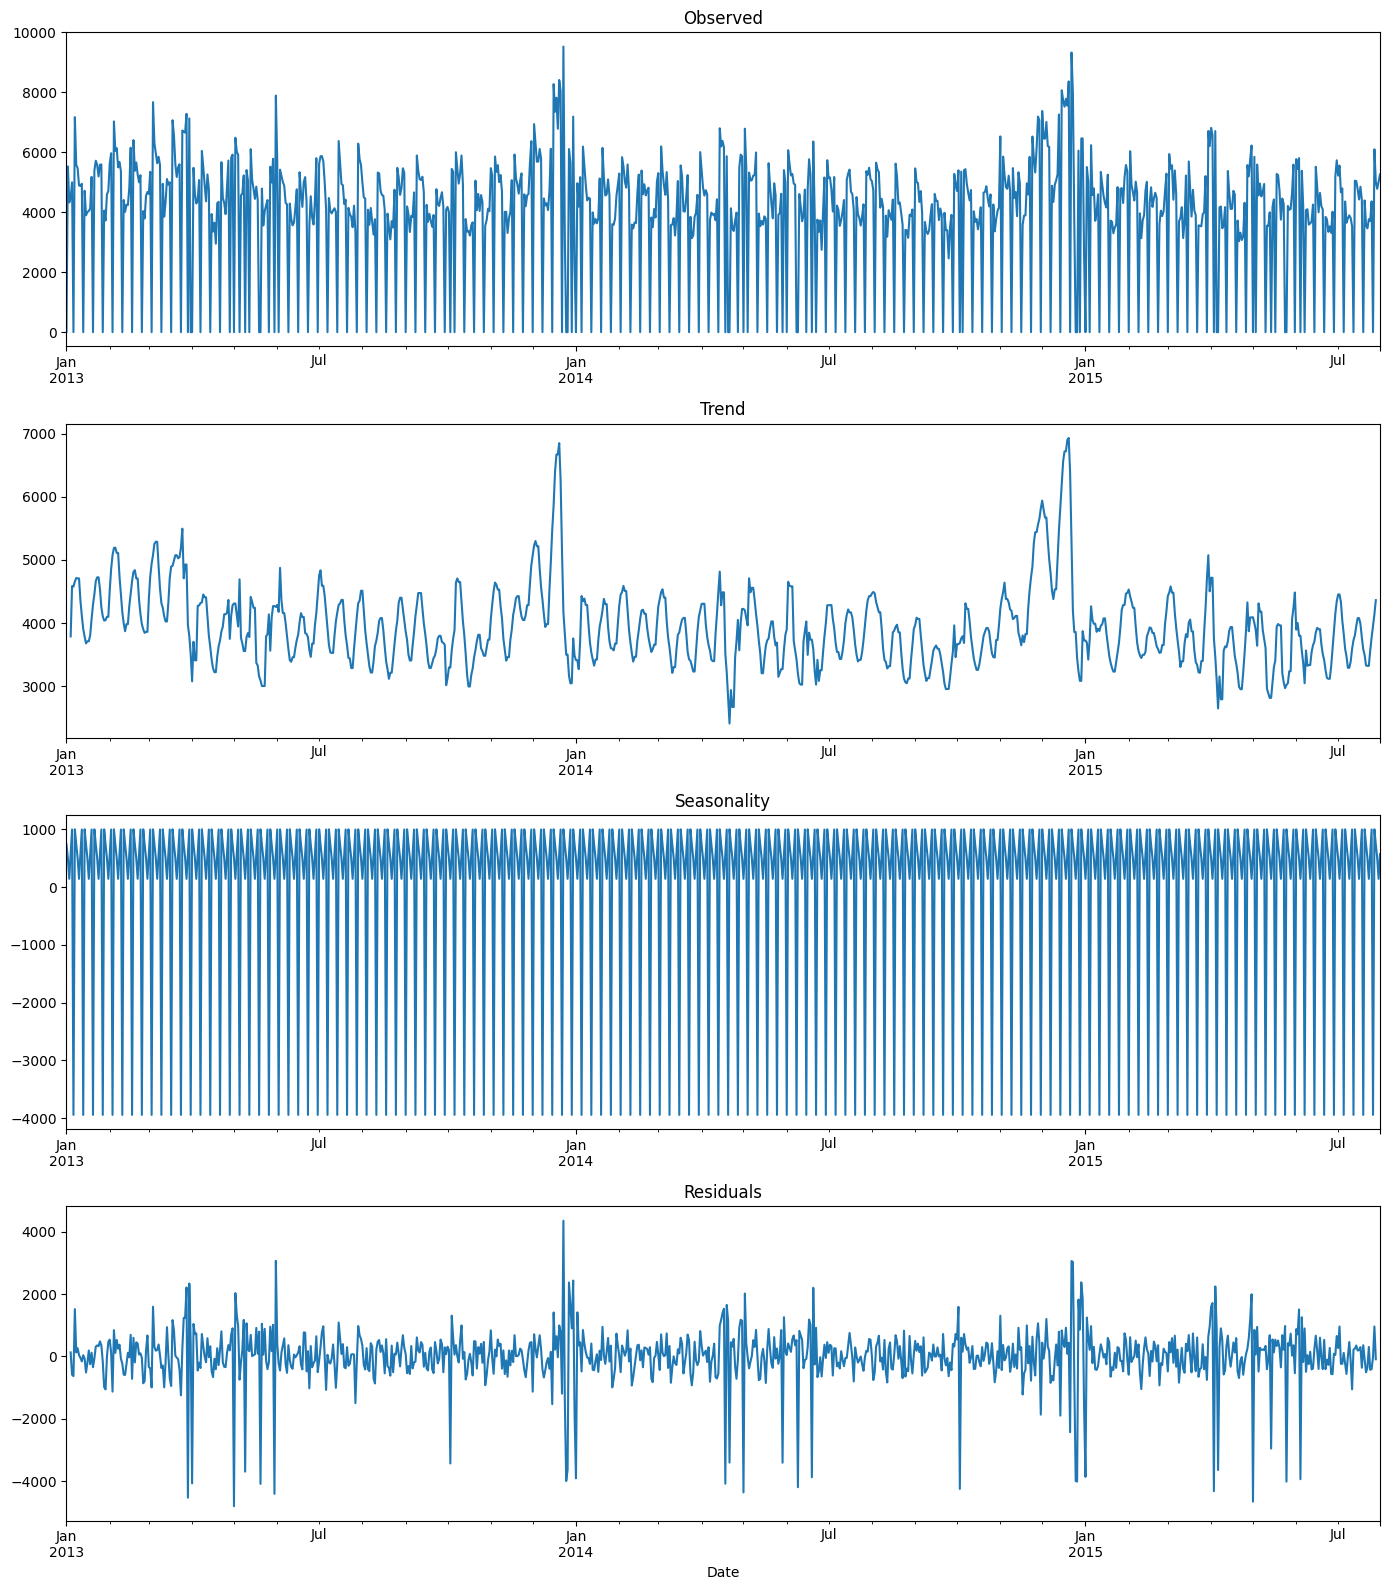

In [29]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 16))
decomposition.observed.plot(ax=ax1)
ax1.set_title('Observed')
ax1.set_xlabel('')
decomposition.trend.plot(ax=ax2)
ax2.set_title('Trend')
ax2.set_xlabel('')
decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Seasonality')
ax3.set_xlabel('')
decomposition.resid.plot(ax=ax4)
ax4.set_title('Residuals')
plt.tight_layout()
plt.show()

In [30]:
stl = STL(store1_daily['Sales'], period=7)
stl_result = stl.fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 16))
stl_result.observed.plot(ax=ax1)
ax1.set_title('Observed')
ax1.set_xlabel('')
stl_result.trend.plot(ax=ax2)
ax2.set_title('Trend')
ax2.set_xlabel('')
stl_result.seasonal.plot(ax=ax3)
ax3.set_title('Seasonality')
ax3.set_xlabel('')
stl_result.resid.plot(ax=ax4)
ax4.set_title('Residuals')
plt.tight_layout()
plt.show()

In [31]:
mstl = MSTL(store1_daily['Sales'], periods=[7, 365])
mstl_result = mstl.fit()

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(14, 20))
mstl_result.observed.plot(ax=ax1)
ax1.set_title('Observed')
ax1.set_xlabel('')
mstl_result.trend.plot(ax=ax2)
ax2.set_title('Trend')
ax2.set_xlabel('')
mstl_result.seasonal['seasonal_7'].plot(ax=ax3)
ax3.set_title('Weekly Seasonality')
ax3.set_xlabel('')
mstl_result.seasonal['seasonal_365'].plot(ax=ax4)
ax4.set_title('Yearly Seasonality')
ax4.set_xlabel('')
mstl_result.resid.plot(ax=ax5)
ax5.set_title('Residuals')
plt.tight_layout()
plt.show()

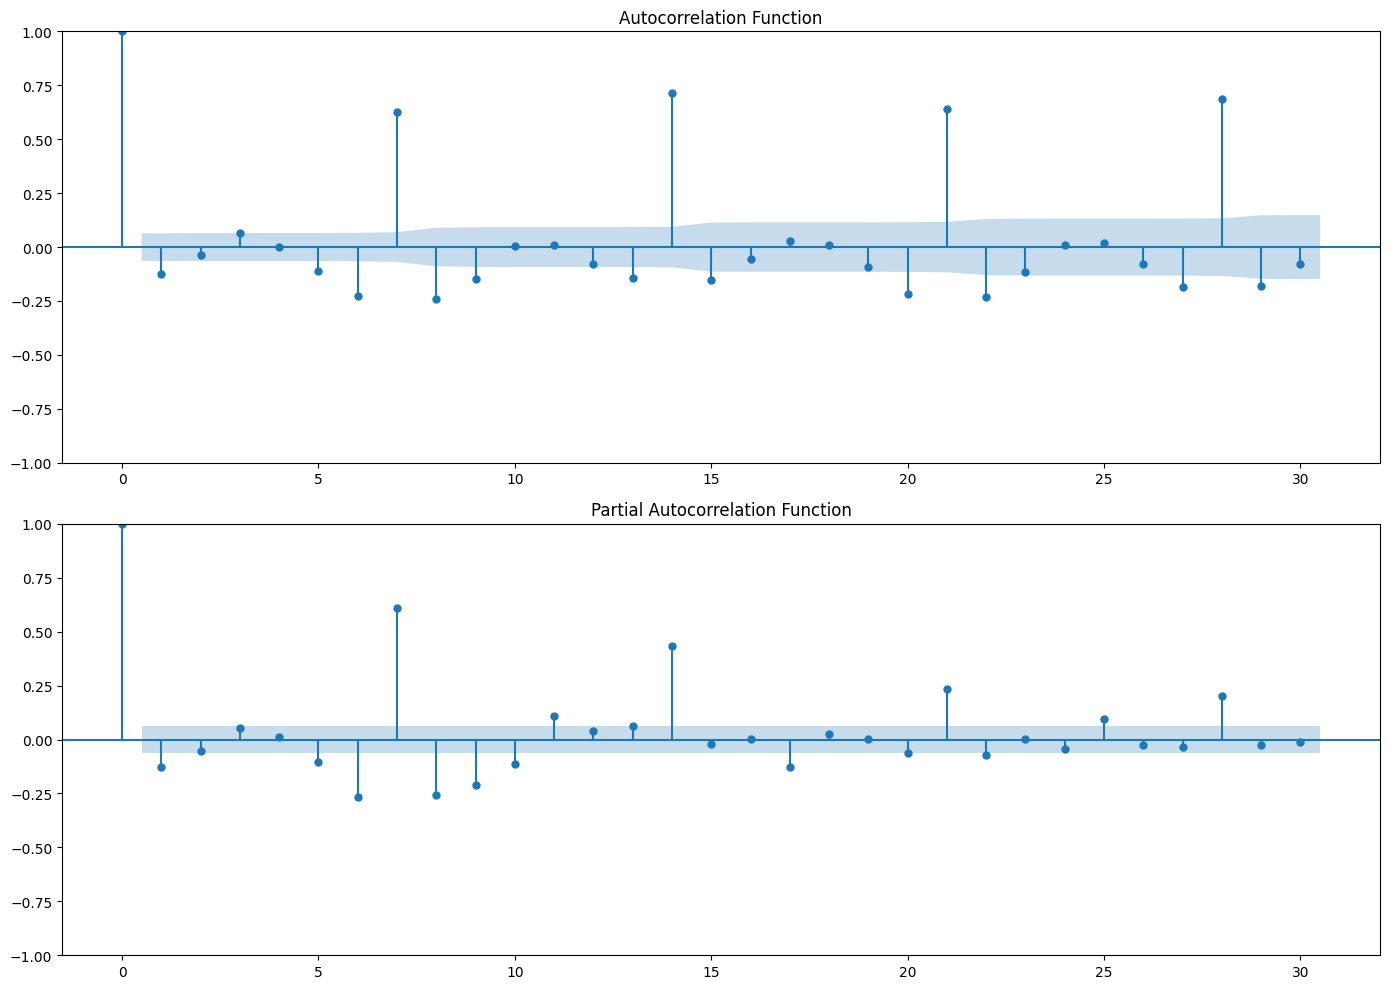

In [32]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
plot_acf(store1_daily['Sales'].dropna(), lags=30, ax=ax1)
ax1.set_title('Autocorrelation Function')
plot_pacf(store1_daily['Sales'].dropna(), lags=30, ax=ax2)
ax2.set_title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

## Simple Forecasting Models

In [33]:
def rmspe(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    y_true_nz = y_true[non_zero_indices]
    y_pred_nz = y_pred[non_zero_indices]
    
    percentage_error = np.abs((y_true_nz - y_pred_nz) / y_true_nz)
    return np.sqrt(np.mean(percentage_error ** 2))

def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    rmspe_val = rmspe(y_true, y_pred)
    
    print(f"{model_name} Results:")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSPE: {rmspe_val:.4f}")
    
    return mse, rmse, mae, rmspe_val

### Moving Average Method

In [34]:
store_id = 1
single_store = train_merged[train_merged['Store'] == store_id].copy()
single_store = single_store[single_store['Open'] == 1]
single_store = single_store.sort_values('Date')

In [35]:
split_date = single_store['Date'].max() - pd.Timedelta(days=48)

train_data = single_store[single_store['Date'] <= split_date]
test_data = single_store[single_store['Date'] > split_date]
y_true = test_data['Sales'].values

Moving Average (window=7) Results:
MSE: 795603.83
RMSE: 891.97
MAE: 749.96
RMSPE: 0.1955


Moving Average (window=30) Results:
MSE: 576431.14
RMSE: 759.23
MAE: 647.21
RMSPE: 0.1700


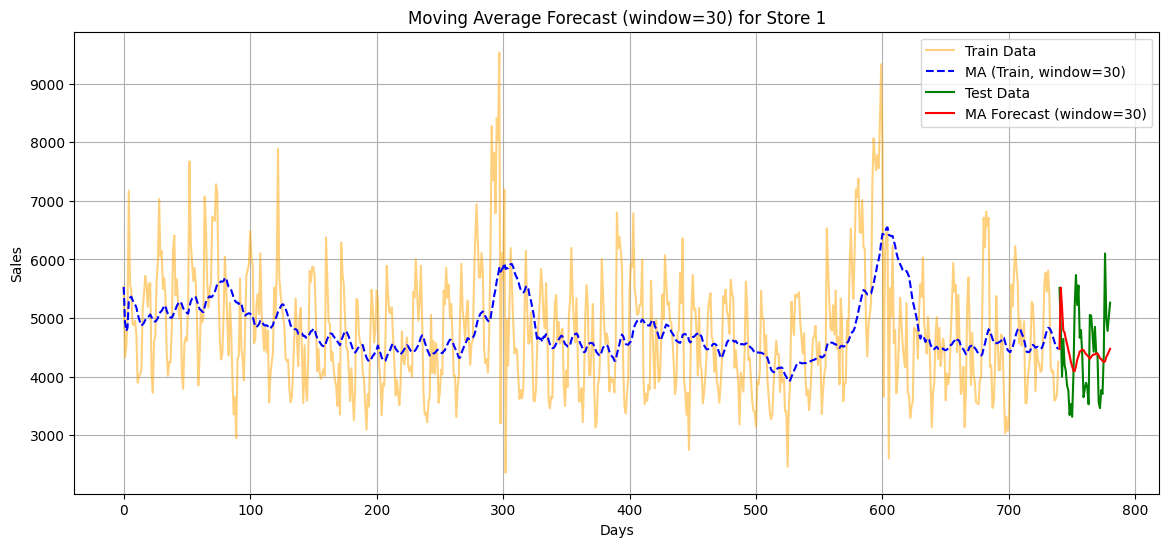

In [36]:
metrics_dict = {}

for window in [7, 30]:
    train_data['MA'] = train_data['Sales'].rolling(window=window, min_periods=1).mean()
    last_ma = train_data['MA'].iloc[-1]

    y_pred_ma = np.array([last_ma] + [test_data['Sales'].iloc[max(0, i-window):i].mean() for i in range(1, len(test_data))])

    ma_metrics = evaluate_model(y_true, y_pred_ma, f"Moving Average (window={window})")
    metrics_dict[window] = ma_metrics

    plt.figure(figsize=(14, 6))
    plt.plot(range(len(train_data)), train_data['Sales'], label='Train Data', color='orange', alpha=0.5)
    plt.plot(range(len(train_data)), train_data['MA'], label=f'MA (Train, window={window})', color='blue', linestyle='--')
    plt.plot(range(len(train_data), len(train_data) + len(y_true)), y_true, label='Test Data', color='green')
    plt.plot(range(len(train_data), len(train_data) + len(y_pred_ma)), y_pred_ma, label=f'MA Forecast (window={window})', color='red')
    plt.title(f'Moving Average Forecast (window={window}) for Store {store_id}')
    plt.xlabel('Days')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.show()

### Comparing Simple Forecasting Methods

In [37]:
models = ["MA-7", "MA-30"]
metrics = pd.DataFrame({
    'Model': models,
    'MSE': [metrics_dict[7][0], metrics_dict[30][0]],
    'RMSE': [metrics_dict[7][1], metrics_dict[30][1]],
    'MAE': [metrics_dict[7][2], metrics_dict[30][2]],
    'RMSPE': [metrics_dict[7][3], metrics_dict[30][3]]
})

print("Comparison of Simple Forecasting Methods:")
metrics.sort_values('RMSPE')

Comparison of Simple Forecasting Methods:


Model            MSE        RMSE         MAE     RMSPE
1  MA-30  576431.135577  759.230621  647.213768  0.169995
0   MA-7  795603.827881  891.966271  749.956039  0.195450

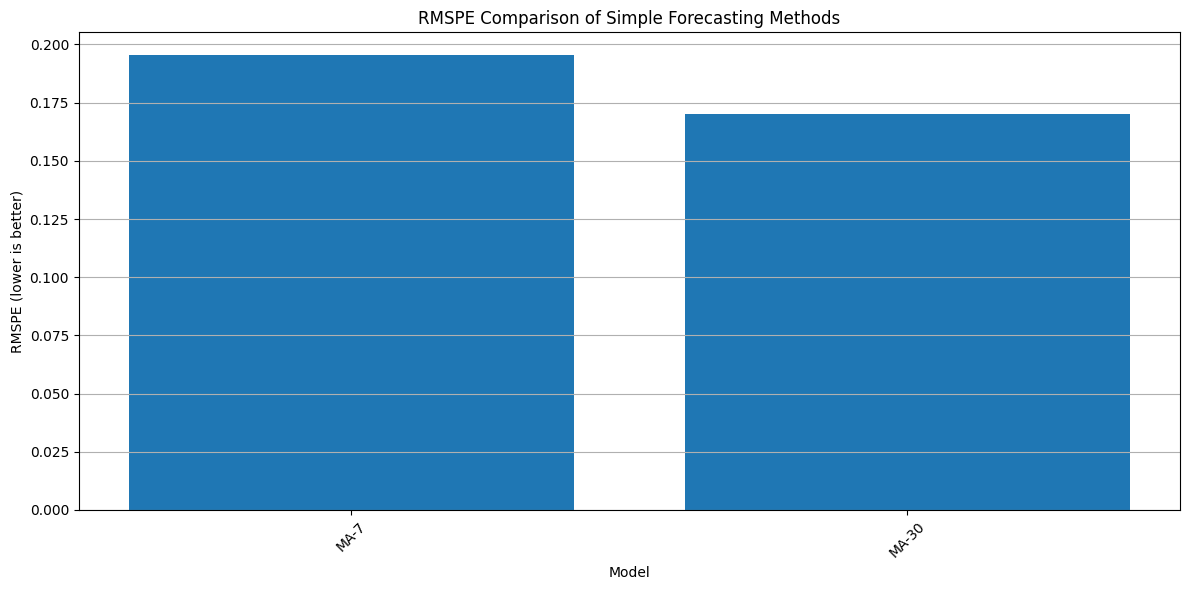

In [38]:
plt.figure(figsize=(12, 6))
plt.bar(metrics['Model'], metrics['RMSPE'])
plt.title('RMSPE Comparison of Simple Forecasting Methods')
plt.xlabel('Model')
plt.ylabel('RMSPE (lower is better)')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

## ETS Models

### Simple Exponential Smoothing

In [39]:
ses_model = SimpleExpSmoothing(train_data['Sales']).fit()
ses_forecast = ses_model.forecast(len(test_data))
ses_metrics = evaluate_model(y_true, ses_forecast, "Simple Exponential Smoothing")

Simple Exponential Smoothing Results:
MSE: 590351.54
RMSE: 768.34
MAE: 638.74
RMSPE: 0.1581


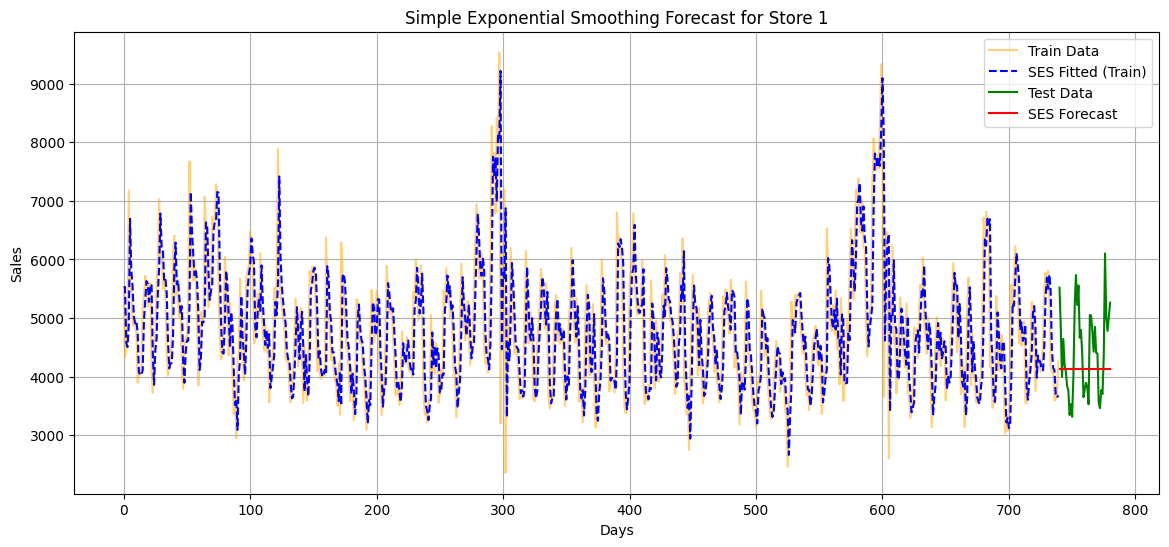

In [40]:
plt.figure(figsize=(14, 6))
plt.plot(range(len(train_data)), train_data['Sales'], label='Train Data', color='orange', alpha=0.5)
plt.plot(range(len(train_data)), ses_model.fittedvalues, label='SES Fitted (Train)', color='blue', linestyle='--')
plt.plot(range(len(train_data), len(train_data) + len(y_true)), y_true, label='Test Data', color='green')
plt.plot(range(len(train_data), len(train_data) + len(ses_forecast)), ses_forecast, label='SES Forecast', color='red')
plt.title(f'Simple Exponential Smoothing Forecast for Store {store_id}')
plt.xlabel('Days')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


### Double Exponential Smoothing

In [41]:
holt_model = Holt(train_data['Sales']).fit()
holt_forecast = holt_model.forecast(len(test_data))
holt_metrics = evaluate_model(y_true, holt_forecast, "Holt's Linear Trend")

Holt's Linear Trend Results:
MSE: 932627.65
RMSE: 965.73
MAE: 748.15
RMSPE: 0.1894


In [42]:
plt.figure(figsize=(14, 6))
plt.plot(range(len(train_data)), train_data['Sales'], label='Train Data', color='orange', alpha=0.5)
plt.plot(range(len(train_data)), holt_model.fittedvalues, label="Holt's Fitted (Train)", color='blue', linestyle='--')
plt.plot(range(len(train_data), len(train_data) + len(y_true)), y_true, label='Test Data', color='green')
plt.plot(range(len(train_data), len(train_data) + len(holt_forecast)), holt_forecast, label="Holt's Forecast", color='red')
plt.title(f"Holt's Linear Trend Forecast for Store {store_id}")
plt.xlabel('Days')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

### Triple Exponential Smoothing

In [43]:
hw_model = ExponentialSmoothing(train_data['Sales'], trend='add', seasonal='add', seasonal_periods=7).fit()
hw_forecast = hw_model.forecast(len(test_data))
hw_metrics = evaluate_model(y_true, hw_forecast, "Holt-Winters Additive")

Holt-Winters Additive Results:
MSE: 1012453.44
RMSE: 1006.21
MAE: 779.72
RMSPE: 0.1960


In [44]:
plt.figure(figsize=(14, 6))
plt.plot(range(len(train_data)), train_data['Sales'], label='Train Data', color='orange', alpha=0.5)
plt.plot(range(len(train_data)), hw_model.fittedvalues, label='HW Fitted (Train)', color='blue', linestyle='--')
plt.plot(range(len(train_data), len(train_data) + len(y_true)), y_true, label='Test Data', color='green')
plt.plot(range(len(train_data), len(train_data) + len(hw_model.forecast(len(y_true)))), hw_model.forecast(len(y_true)), label='HW Forecast', color='red')
plt.title(f'Holt-Winters Additive Forecast for Store {store_id}')
plt.xlabel('Days')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

### Comparing ETS Models

In [45]:
ets_models = ["Simple Exponential Smoothing", "Holt's Linear", "Holt-Winters (Add)"]
ets_metrics = pd.DataFrame({
    'Model': ets_models,
    'MSE': [ses_metrics[0], holt_metrics[0], hw_metrics[0]],
    'RMSE': [ses_metrics[1], holt_metrics[1], hw_metrics[1]],
    'MAE': [ses_metrics[2], holt_metrics[2], hw_metrics[2]],
    'RMSPE': [ses_metrics[3], holt_metrics[3], hw_metrics[3]]
})

print("Comparison of ETS Models:")
ets_metrics.sort_values('RMSPE')

Comparison of ETS Models:


Model           MSE         RMSE         MAE  \
0  Simple Exponential Smoothing  5.903515e+05   768.343374  638.735125   
1                 Holt's Linear  9.326276e+05   965.726486  748.151304   
2            Holt-Winters (Add)  1.012453e+06  1006.207455  779.715767   

      RMSPE  
0  0.158086  
1  0.189432  
2  0.195972

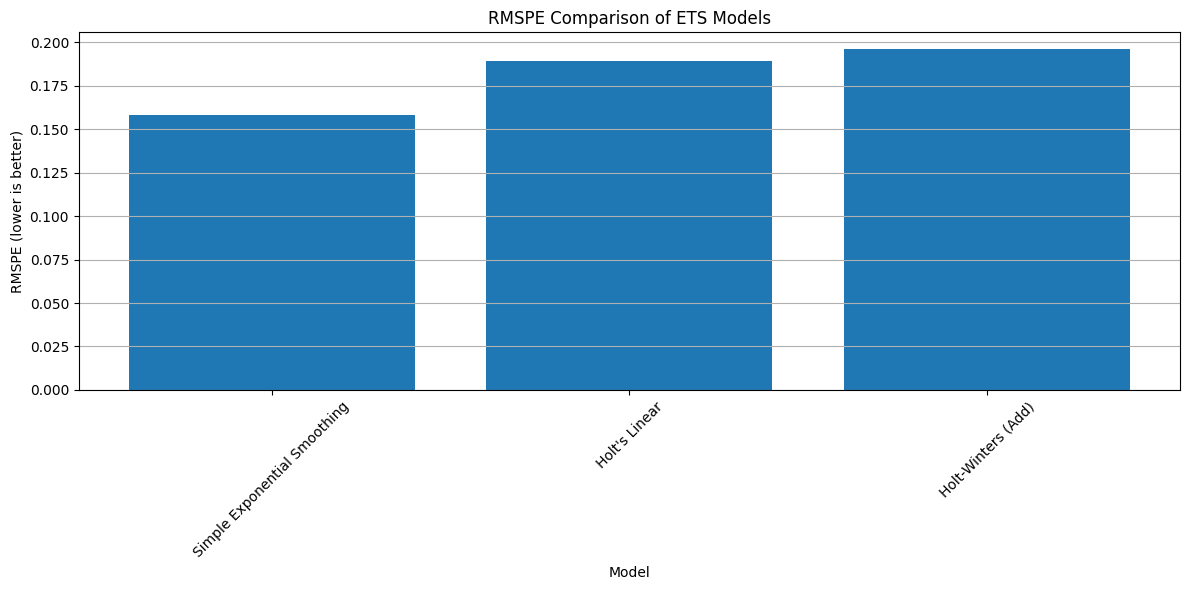

In [46]:
plt.figure(figsize=(12, 6))
plt.bar(ets_metrics['Model'], ets_metrics['RMSPE'])
plt.title('RMSPE Comparison of ETS Models')
plt.xlabel('Model')
plt.ylabel('RMSPE (lower is better)')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

## ARIMA Models

### Determining ARIMA Parameters

In [47]:
decomposition = seasonal_decompose(single_store['Sales'], model='additive', period=7)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 16))
decomposition.observed.plot(ax=ax1)
ax1.set_title('Observed')
ax1.set_xlabel('')
decomposition.trend.plot(ax=ax2)
ax2.set_title('Trend')
ax2.set_xlabel('')
decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Seasonality')
ax3.set_xlabel('')
decomposition.resid.plot(ax=ax4)
ax4.set_title('Residuals')
plt.tight_layout()
plt.show()

In [48]:
check_stationarity_tests(single_store['Sales'])

ADF Statistic: -5.3996
p-value: 0.0000
Critical Value (1%): -3.4389
Critical Value (5%): -2.8653
Critical Value (10%): -2.5688
ADF Test: The series is likely stationary.

----------------------------------------

KPSS Statistic: 0.2869
p-value: 0.1000
Critical Value (10%): 0.3470
Critical Value (5%): 0.4630
Critical Value (2.5%): 0.5740
Critical Value (1%): 0.7390
KPSS Test: The series is likely stationary.


In [49]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
plot_acf(single_store['Sales'].dropna(), lags=30, ax=ax1)
ax1.set_title('Autocorrelation Function')
plot_pacf(single_store['Sales'].dropna(), lags=30, ax=ax2)
ax2.set_title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

### ARIMA Models

In [50]:
def fit_evaluate_arima(train_ts, valid_ts, order):
    model = ARIMA(train_ts, order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(valid_ts))
    metrics = evaluate_model(valid_ts, forecast, f"ARIMA{order}")

    plt.figure(figsize=(14, 6))
    plt.plot(range(len(train_ts)), train_ts, label='Train Data', color='orange', alpha=0.5)
    plt.plot(range(len(train_ts)), model_fit.fittedvalues, label=f'ARIMA{order} Fitted (Train)', color='blue', linestyle='--')
    plt.plot(range(len(train_ts), len(train_ts) + len(valid_ts)), valid_ts, label='Test Data', color='green')
    plt.plot(range(len(train_ts), len(train_ts) + len(forecast)), forecast, label=f'ARIMA{order} Forecast', color='red')
    plt.title(f'ARIMA{order} Forecast')
    plt.xlabel('Days')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.show()

    return metrics, forecast


Fitting ARIMA(1, 1, 1) model...
ARIMA(1, 1, 1) Results:
MSE: 632057.21
RMSE: 795.02
MAE: 664.41
RMSPE: 0.2051


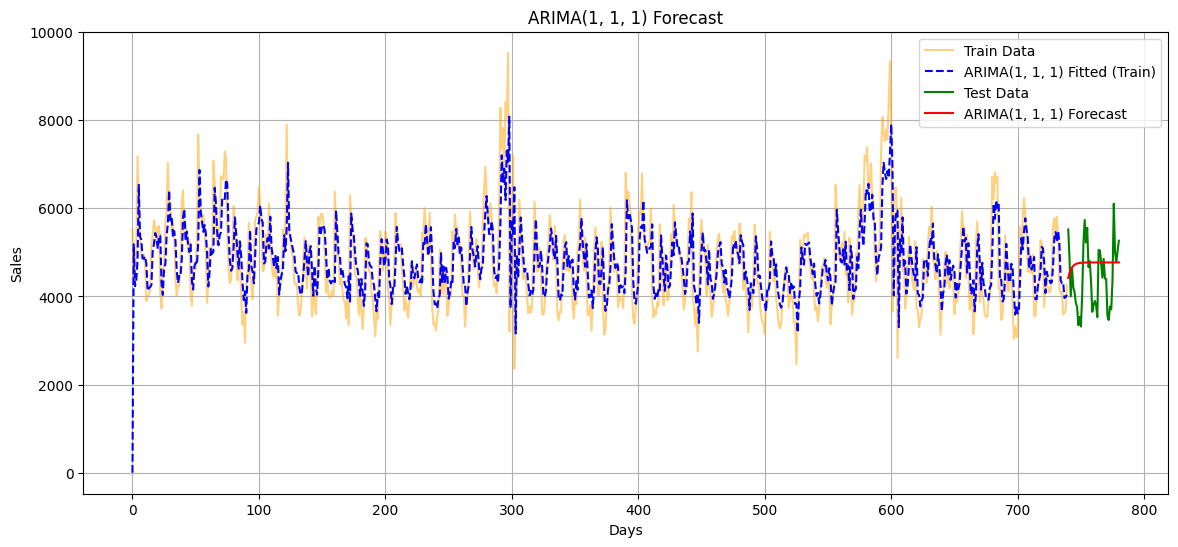


Fitting ARIMA(0, 1, 1) model...
ARIMA(0, 1, 1) Results:
MSE: 591424.62
RMSE: 769.04
MAE: 639.05
RMSPE: 0.1581


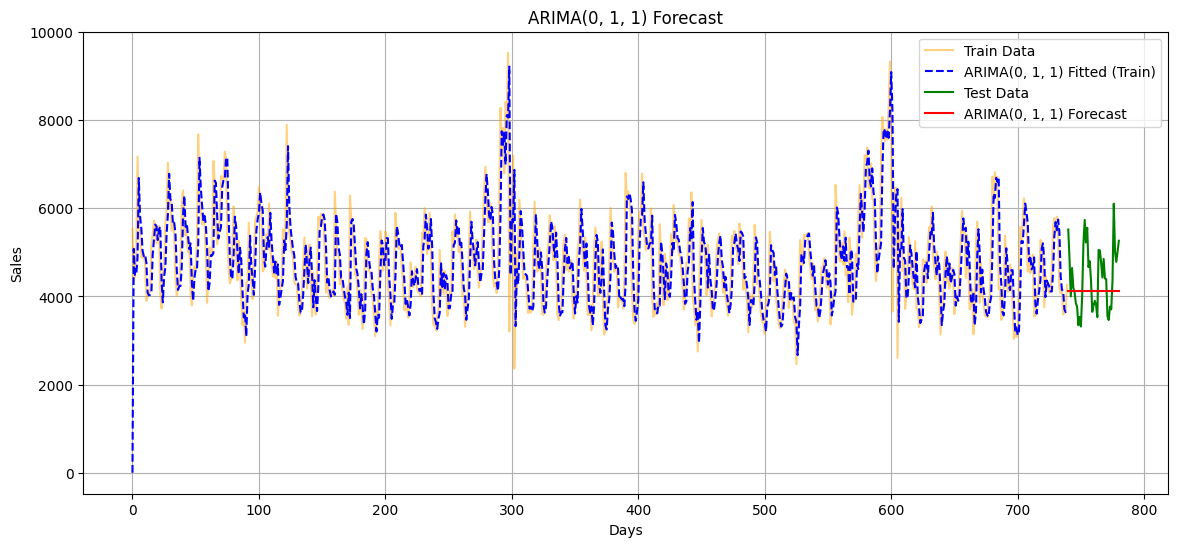


Fitting ARIMA(1, 1, 0) model...
ARIMA(1, 1, 0) Results:
MSE: 574373.90
RMSE: 757.87
MAE: 633.71
RMSPE: 0.1576


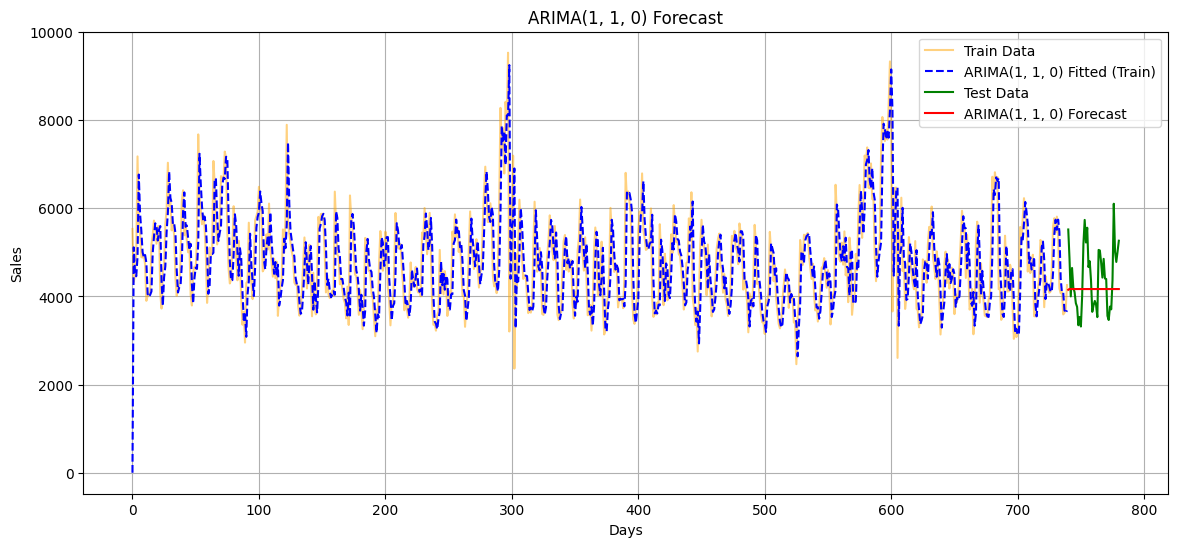


Fitting ARIMA(2, 1, 2) model...
ARIMA(2, 1, 2) Results:
MSE: 628261.86
RMSE: 792.63
MAE: 661.53
RMSPE: 0.2040


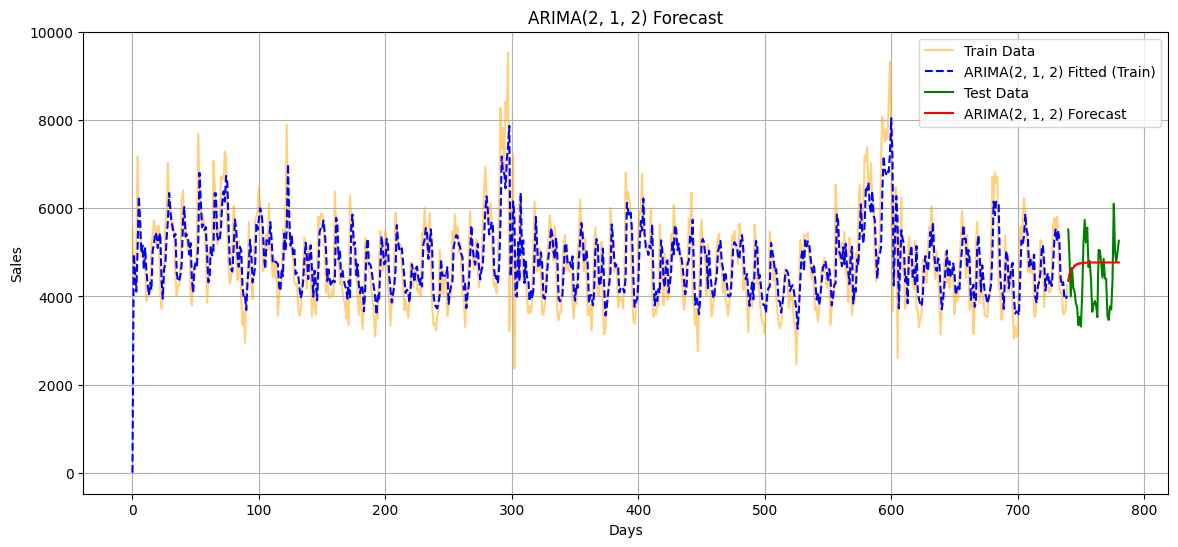


Fitting ARIMA(2, 1, 0) model...
ARIMA(2, 1, 0) Results:
MSE: 577884.73
RMSE: 760.19
MAE: 634.90
RMSPE: 0.1577


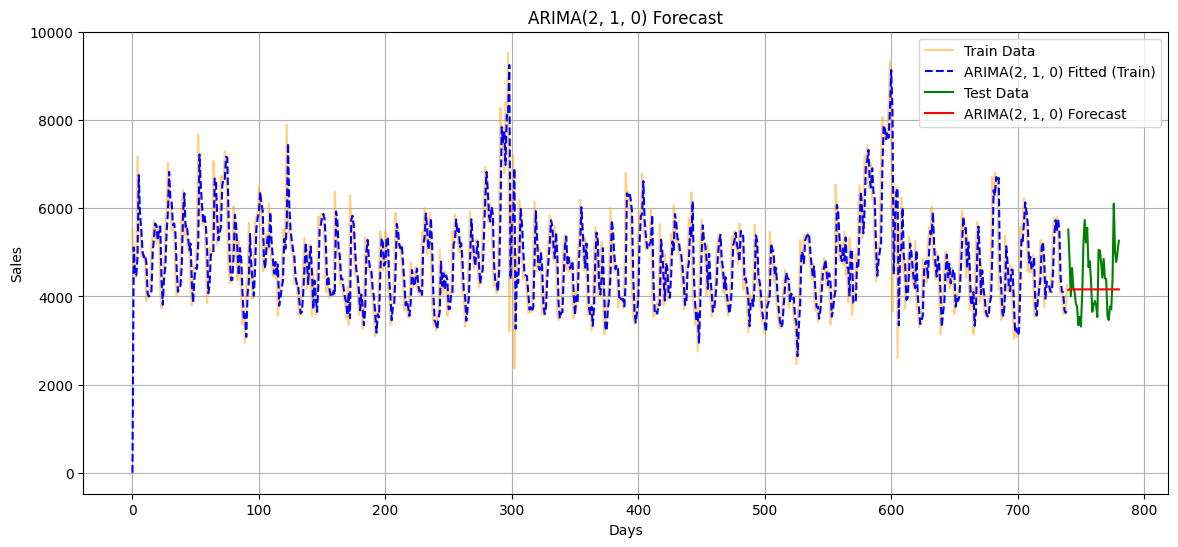


Fitting ARIMA(0, 1, 2) model...
ARIMA(0, 1, 2) Results:
MSE: 615859.68
RMSE: 784.77
MAE: 645.89
RMSPE: 0.1593


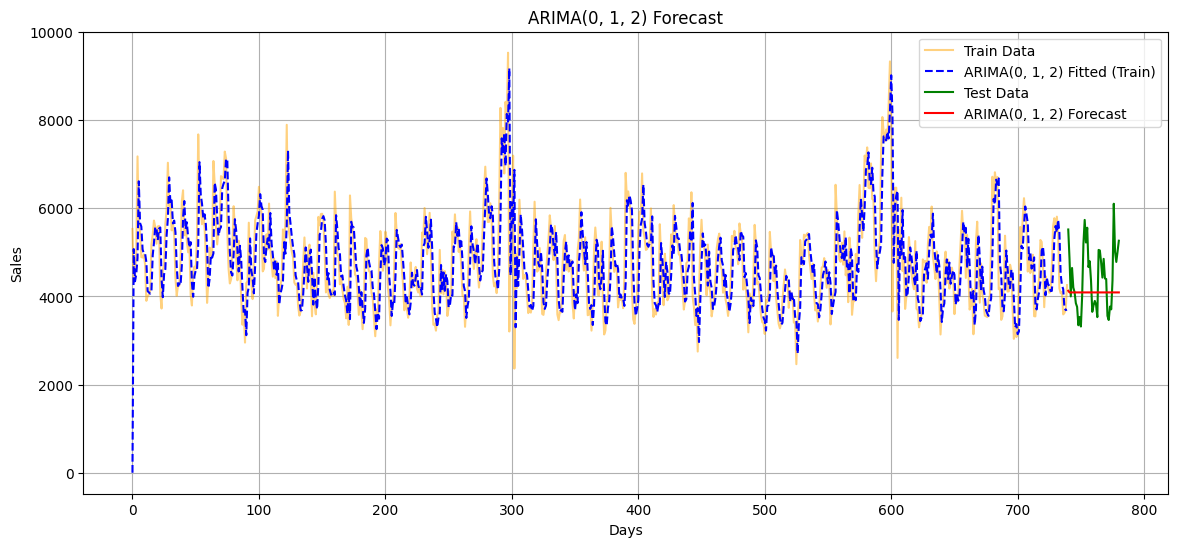

In [51]:
arima_orders = [
    (1, 1, 1),
    (0, 1, 1),
    (1, 1, 0),
    (2, 1, 2),
    (2, 1, 0),
    (0, 1, 2),
]

arima_results = []

for order in arima_orders:
    print(f"\nFitting ARIMA{order} model...")
    metrics, forecast = fit_evaluate_arima(train_data['Sales'], test_data['Sales'], order)
    arima_results.append((f"ARIMA{order}", metrics, forecast))

### SARIMA Models

In [52]:
def fit_evaluate_sarima(train_ts, valid_ts, order, seasonal_order):
    model = SARIMAX(train_ts, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(valid_ts))
    metrics = evaluate_model(valid_ts, forecast, f"SARIMA{order}x{seasonal_order}")

    plt.figure(figsize=(14, 6))
    plt.plot(range(len(train_ts)), train_ts, label='Train Data', color='orange', alpha=0.5)
    plt.plot(range(len(train_ts)), model_fit.fittedvalues, label=f'SARIMA{order}x{seasonal_order} Fitted (Train)', color='blue', linestyle='--')
    plt.plot(range(len(train_ts), len(train_ts) + len(valid_ts)), valid_ts, label='Test Data', color='green')
    plt.plot(range(len(train_ts), len(train_ts) + len(forecast)), forecast, label=f'SARIMA{order}x{seasonal_order} Forecast', color='red')
    plt.title(f'SARIMA{order}x{seasonal_order} Forecast')
    plt.xlabel('Days')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.show()

    return metrics, forecast


Fitting SARIMA(1, 1, 1)x(1, 1, 1, 7) model...
SARIMA(1, 1, 1)x(1, 1, 1, 7) Results:
MSE: 569783.58
RMSE: 754.84
MAE: 634.12
RMSPE: 0.1576


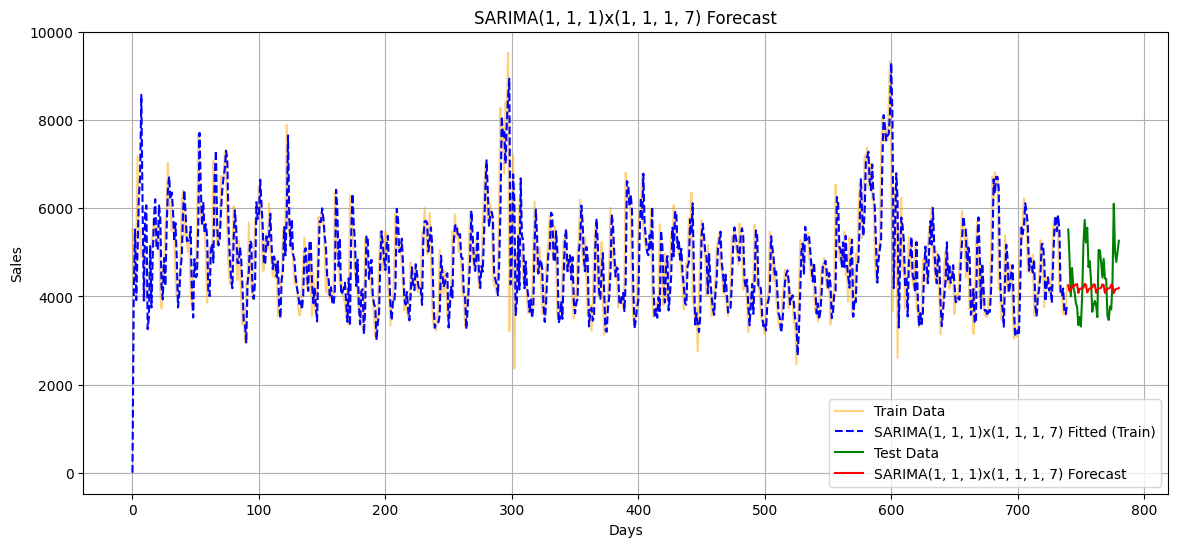


Fitting SARIMA(0, 1, 1)x(1, 1, 0, 7) model...
SARIMA(0, 1, 1)x(1, 1, 0, 7) Results:
MSE: 3215407.21
RMSE: 1793.16
MAE: 1472.67
RMSPE: 0.3652


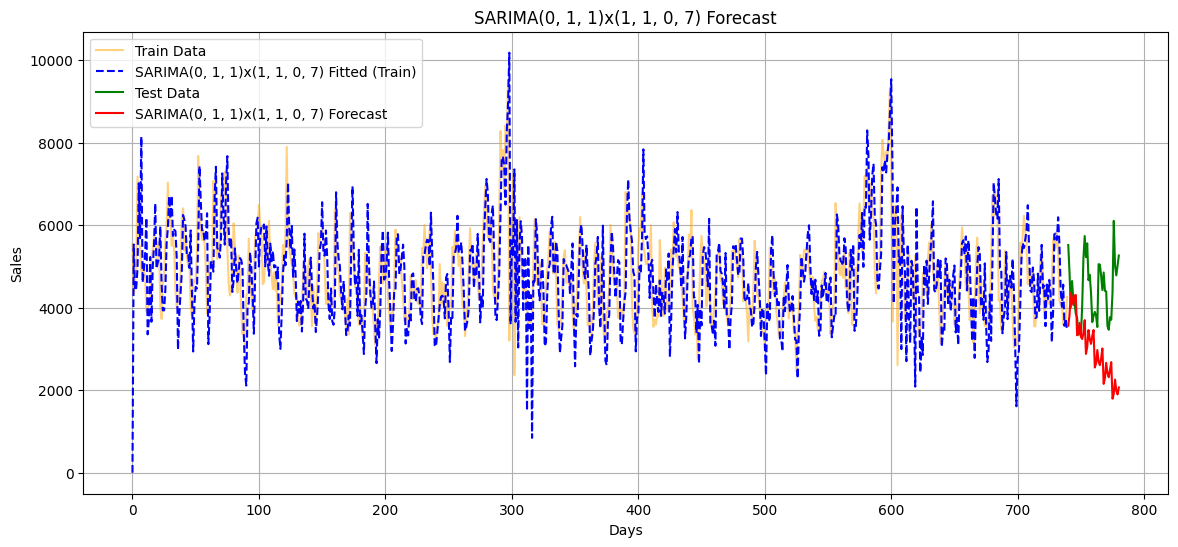


Fitting SARIMA(1, 1, 0)x(0, 1, 1, 7) model...
SARIMA(1, 1, 0)x(0, 1, 1, 7) Results:
MSE: 608288.75
RMSE: 779.93
MAE: 646.39
RMSPE: 0.1591


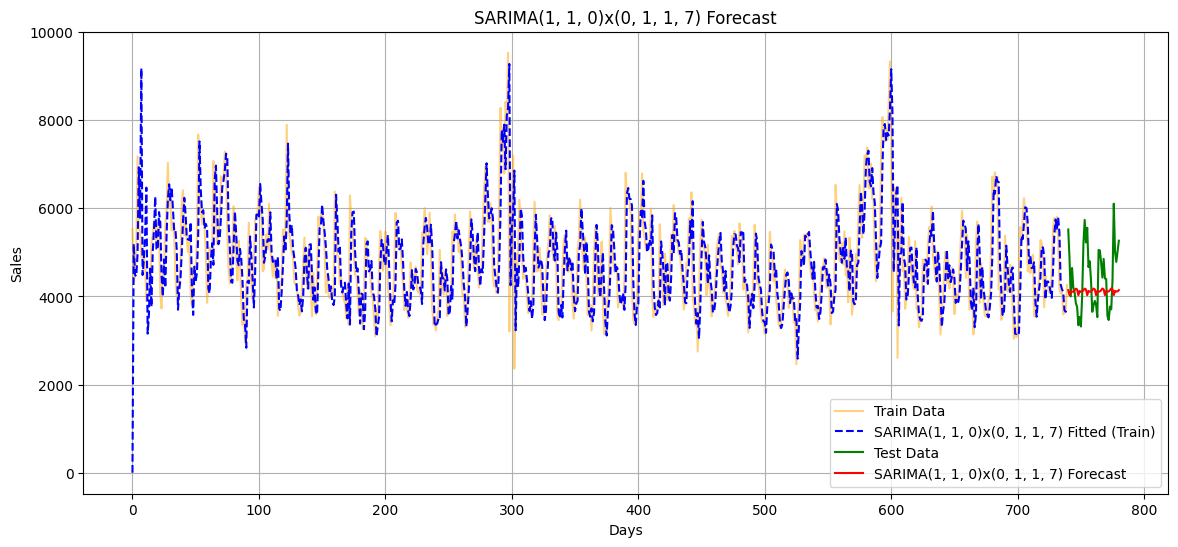


Fitting SARIMA(2, 1, 2)x(1, 0, 1, 7) model...
SARIMA(2, 1, 2)x(1, 0, 1, 7) Results:
MSE: 573570.59
RMSE: 757.34
MAE: 644.53
RMSPE: 0.1903


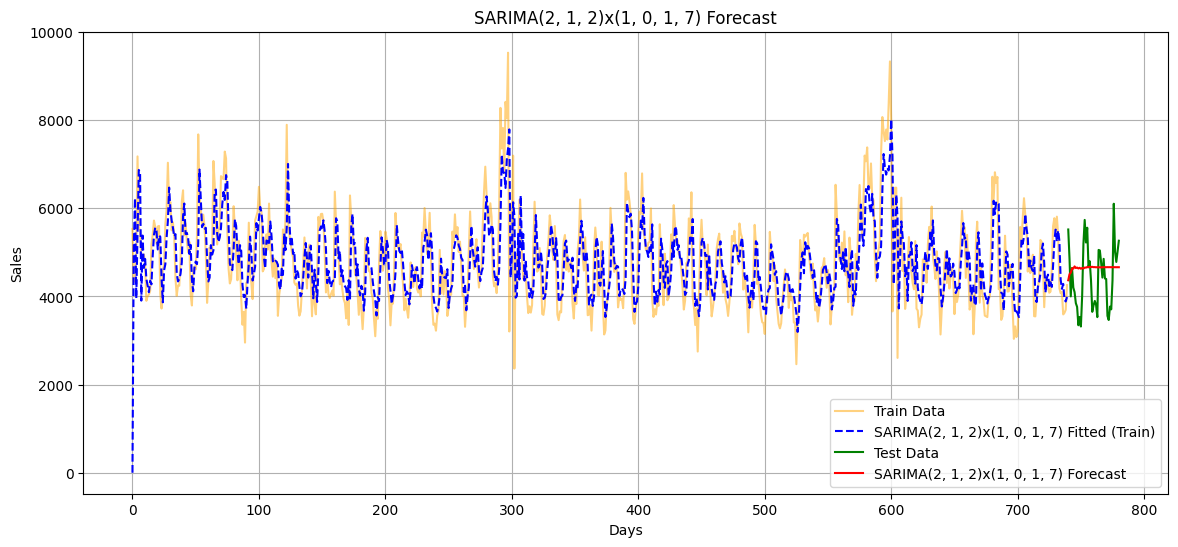


Fitting SARIMA(2, 1, 0)x(0, 1, 1, 7) model...
SARIMA(2, 1, 0)x(0, 1, 1, 7) Results:
MSE: 611520.75
RMSE: 782.00
MAE: 647.30
RMSPE: 0.1592


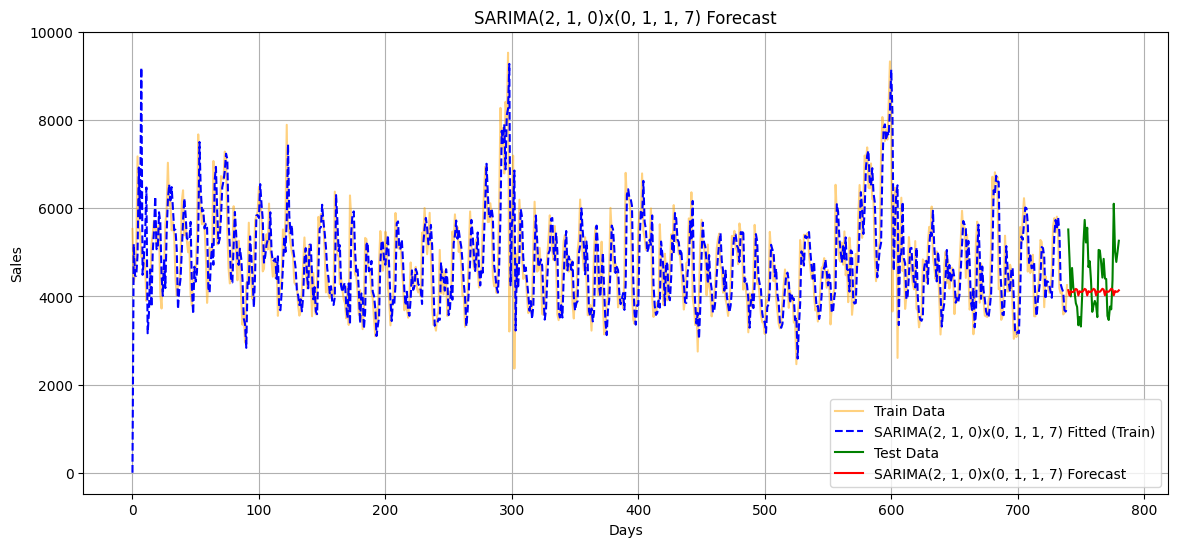


Fitting SARIMA(0, 1, 2)x(1, 1, 0, 7) model...
SARIMA(0, 1, 2)x(1, 1, 0, 7) Results:
MSE: 3535186.51
RMSE: 1880.21
MAE: 1549.77
RMSPE: 0.3845


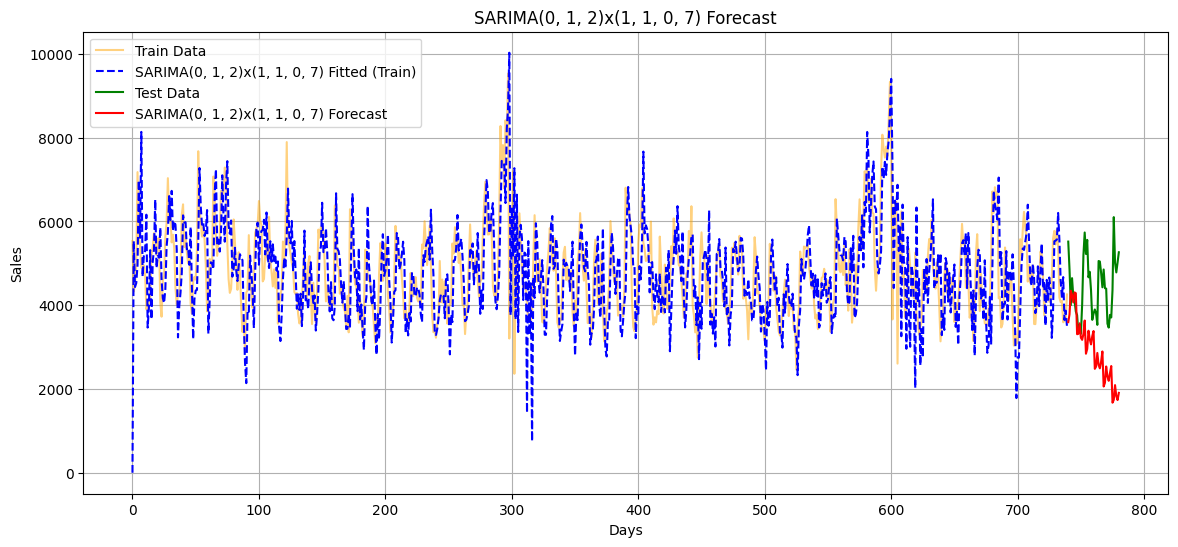

In [53]:
sarima_params = [
    # (order, seasonal_order)
    ((1, 1, 1), (1, 1, 1, 7)),
    ((0, 1, 1), (1, 1, 0, 7)),
    ((1, 1, 0), (0, 1, 1, 7)),
    ((2, 1, 2), (1, 0, 1, 7)),
    ((2, 1, 0), (0, 1, 1, 7)),
    ((0, 1, 2), (1, 1, 0, 7)),
]


for order, seasonal_order in sarima_params:
    print(f"\nFitting SARIMA{order}x{seasonal_order} model...")
    metrics, forecast = fit_evaluate_sarima(train_data['Sales'], test_data['Sales'], order, seasonal_order)
    arima_results.append((f"SARIMA{order}x{seasonal_order}", metrics, forecast))

### Comparing ARIMA Models

In [54]:
arima_metrics = pd.DataFrame({
    'Model': [result[0] for result in arima_results],
    'MSE': [result[1][0] for result in arima_results],
    'RMSE': [result[1][1] for result in arima_results],
    'MAE': [result[1][2] for result in arima_results],
    'RMSPE': [result[1][3] for result in arima_results]
})

print("Comparison of ARIMA Models:")
arima_metrics.sort_values('RMSPE')

Comparison of ARIMA Models:


Model           MSE         RMSE          MAE  \
6   SARIMA(1, 1, 1)x(1, 1, 1, 7)  5.697836e+05   754.840102   634.116170   
2                 ARIMA(1, 1, 0)  5.743739e+05   757.874591   633.714620   
4                 ARIMA(2, 1, 0)  5.778847e+05   760.187296   634.899660   
1                 ARIMA(0, 1, 1)  5.914246e+05   769.041364   639.052992   
8   SARIMA(1, 1, 0)x(0, 1, 1, 7)  6.082888e+05   779.928685   646.389174   
10  SARIMA(2, 1, 0)x(0, 1, 1, 7)  6.115207e+05   781.997920   647.302460   
5                 ARIMA(0, 1, 2)  6.158597e+05   784.767280   645.887009   
9   SARIMA(2, 1, 2)x(1, 0, 1, 7)  5.735706e+05   757.344431   644.533579   
3                 ARIMA(2, 1, 2)  6.282619e+05   792.629712   661.533677   
0                 ARIMA(1, 1, 1)  6.320572e+05   795.020258   664.408240   
7   SARIMA(0, 1, 1)x(1, 1, 0, 7)  3.215407e+06  1793.155657  1472.665751   
11  SARIMA(0, 1, 2)x(1, 1, 0, 7)  3.535187e+06  1880.209166  1549.770714   

       RMSPE  
6   0.157591  
2   0.157608  
4   0.157690  
1   0.158131  
8   0.159064  
10  0.159215  
5   0.159257  
9   0.190281  
3   0.204005  
0   0.205080  
7   0.365200  
11  0.384526

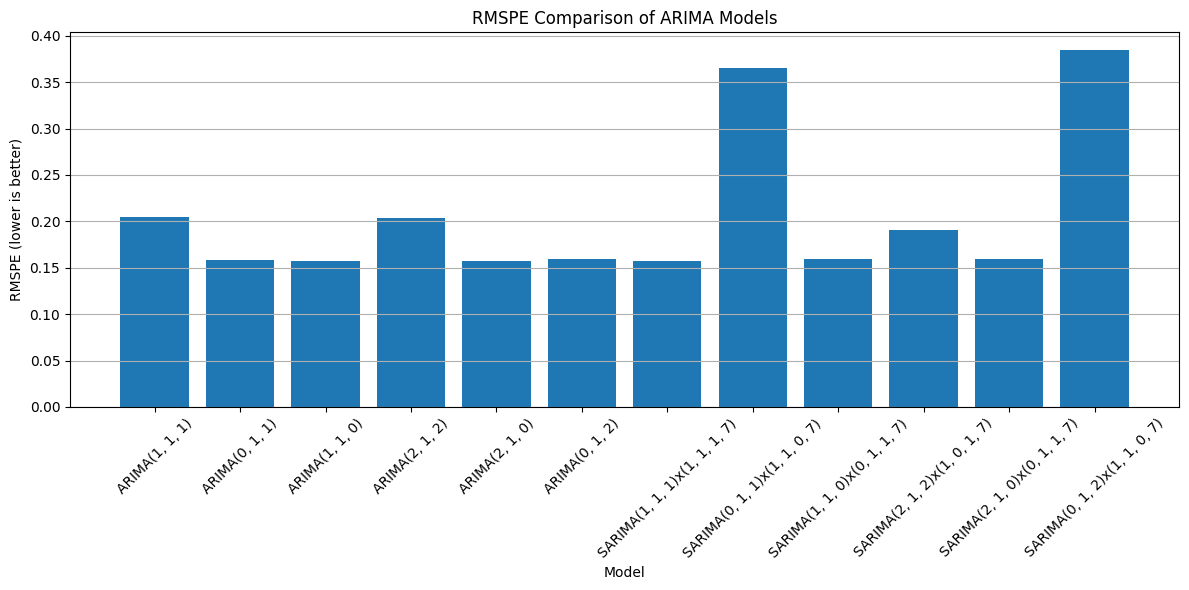

In [55]:
plt.figure(figsize=(12, 6))
plt.bar(arima_metrics['Model'], arima_metrics['RMSPE'])
plt.title('RMSPE Comparison of ARIMA Models')
plt.xlabel('Model')
plt.ylabel('RMSPE (lower is better)')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

## Prophet Models

### Preparing Prophet

In [56]:
train_prophet = train_data.reset_index()[["Date", "Sales"]].copy()
train_prophet.columns = ["ds", "y"] 

test_prophet = test_data.reset_index()[["Date", "Sales"]].copy()
test_prophet.columns = ["ds", "y"]

### Prophet Model

In [57]:
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
prophet_model.fit(train_prophet)
future = prophet_model.make_future_dataframe(periods=len(test_prophet), freq='D')
forecast_prophet = prophet_model.predict(future)

05:39:24 - cmdstanpy - INFO - Chain [1] start processing
05:39:24 - cmdstanpy - INFO - Chain [1] done processing


Prophet Forecast Results:
MSE: 497847.07
RMSE: 705.58
MAE: 608.89
RMSPE: 0.1650


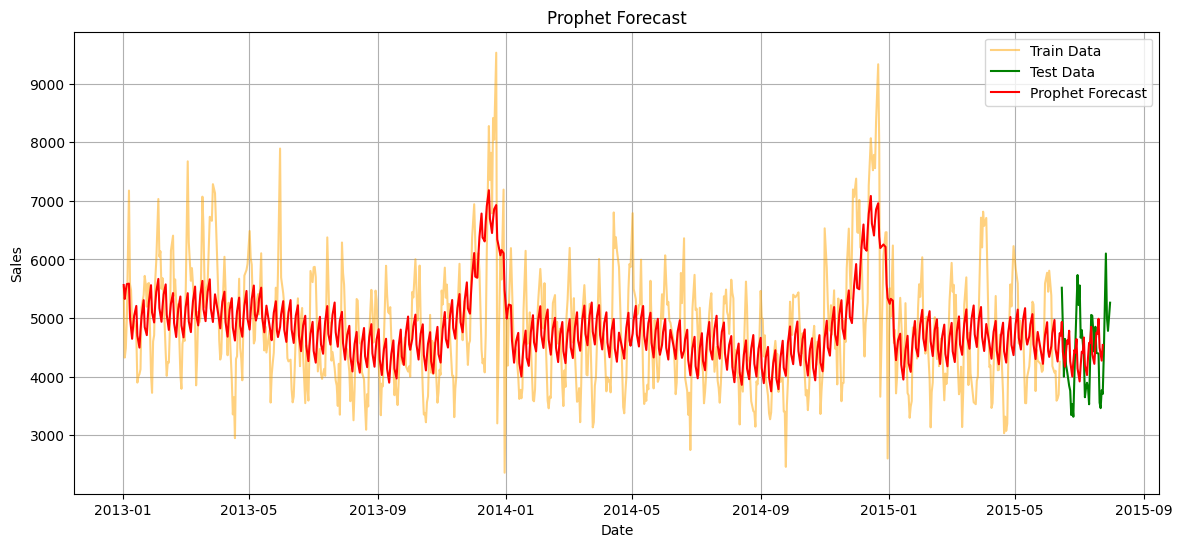

In [58]:
merged = pd.merge(test_prophet, forecast_prophet[['ds', 'yhat']], on='ds', how='inner')
prophet_pred = merged['yhat'].values
y_true = merged['y'].values

prophet_metrics = evaluate_model(y_true, prophet_pred, "Prophet Forecast")
plt.figure(figsize=(14, 6))
plt.plot(train_prophet['ds'], train_prophet['y'], label='Train Data', color='orange', alpha=0.5)
plt.plot(test_prophet['ds'], test_prophet['y'], label='Test Data', color='green')
plt.plot(forecast_prophet['ds'], forecast_prophet['yhat'], label='Prophet Forecast', color='red')
plt.title('Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

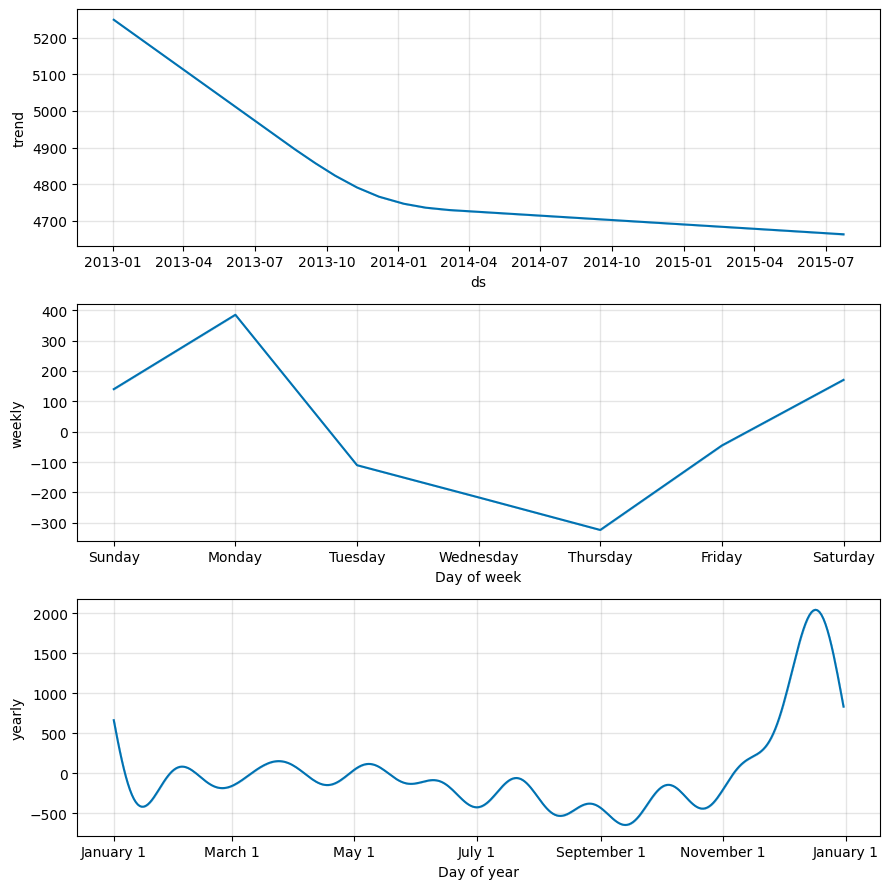

In [59]:
fig = prophet_model.plot_components(forecast_prophet)
plt.tight_layout()
plt.show()

## Machine Learning Models

### Feature Engineering

In [60]:
def create_features_with_lags(df, lags=[1, 7], rolling_windows=[7, 14]):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])

    
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)

    # One-hot encode StateHoliday
    df['StateHoliday'] = df['StateHoliday'].astype(str)
    for cat in ['a', 'b', 'c']:
        df[f'StateHoliday_{cat}'] = (df['StateHoliday'] == cat).astype(int)

    
    df = df.sort_values(by=['Store', 'Date'])

    
    for lag in lags:
        df[f'Sales_lag_{lag}'] = df.groupby('Store')['Sales'].shift(lag)

    
    for window in rolling_windows:
        df[f'Sales_roll_mean_{window}'] = (df.groupby('Store')['Sales'].shift(1).rolling(window=window).mean().reset_index(0, drop=True))
        df[f'Sales_roll_std_{window}'] = (df.groupby('Store')['Sales'].shift(1).rolling(window=window).std().reset_index(0, drop=True))

    # Drop early rows based on the maximum lag/rolling window
    max_lag = max(max(lags, default=0), max(rolling_windows, default=0))
    df = df.groupby('Store').apply(lambda g: g.iloc[max_lag:]).reset_index(drop=True)

    return df


### Preparing Data

In [61]:
test['Sales'] = np.nan
combined = pd.concat([train, test], sort=False)

combined_fe = create_features_with_lags(combined)

# Filter for a specific store and open days
store_data = combined_fe[(combined_fe['Store'] == store_id) & (combined_fe['Open'] == 1)]

# Split into train/test
train_ml = store_data[store_data['Sales'].notna()].copy()
test_ml = store_data[store_data['Sales'].isna()].copy()
test_ml.drop(columns=['Sales'], inplace=True)



print("Train rows:", train_ml.shape[0])
print("Test rows:", test_ml.shape[0])


Train rows: 770
Test rows: 41


In [62]:
target_col = 'Sales'
drop_cols = [target_col , 'Date' , 'Customers' , 'Id' , 'StateHoliday' , 'StoreType' , 'Assortment' , 'PromoInterval']
features = [col for col in train_ml.columns if col not in drop_cols]
fill_cols = ['Sales_lag_1', 'Sales_lag_7', 'Sales_roll_mean_7', 'Sales_roll_std_7', 'Sales_roll_mean_14', 'Sales_roll_std_14']

for col in fill_cols:
    train_ml[col] = train_ml[col].fillna(train_ml[col].median())

for col in fill_cols:
    test_ml[col] = test_ml[col].fillna(train_ml[col].median()) 

In [63]:
train_ml_sorted = train_ml.sort_values("Date")

split_date = train_ml_sorted["Date"].quantile(0.9)  

train_data = train_ml_sorted[train_ml_sorted["Date"] < split_date]
valid_data = train_ml_sorted[train_ml_sorted["Date"] >= split_date]

x_train = train_data[features]
y_train = train_data[target_col]
x_valid = valid_data[features]
y_valid = valid_data[target_col]


In [64]:
print(f"X_train shape: {x_train.shape}")
print(f"y_train shape:  {y_train.shape}")
print(f"X_valid shape: {x_valid.shape}")
print(f"y_valid shape:  {y_valid.shape}")

X_train shape: (693, 19)
y_train shape:  (693,)
X_valid shape: (77, 19)
y_valid shape:  (77,)


### Random Forest 

In [65]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(x_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_split=10, n_jobs=-1,
                      random_state=42)

In [66]:
rf_predictions = rf_model.predict(x_valid)

In [67]:
rf_metrics = evaluate_model(y_valid, rf_predictions, "Random Forest")

Random Forest Results:
MSE: 147395.78
RMSE: 383.92
MAE: 309.88
RMSPE: 0.0856


In [68]:
train_predictions = rf_model.predict(x_train)

plt.figure(figsize=(14, 6))
plt.plot(train_data['Date'], y_train, label='Train Data', color='orange', alpha=0.5)
plt.plot(train_data['Date'], train_predictions, label='Train Predictions', color='blue', linestyle='--')
plt.plot(valid_data['Date'], y_valid, label='Test Data', color='green')
plt.plot(valid_data['Date'], rf_predictions, label='Random Forest Predictions', color='red')
plt.title('Random Forest Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

In [69]:
feature_importance = pd.DataFrame(
    {'feature': x_train.columns, 'importance': rf_model.feature_importances_}
).sort_values('importance', ascending=True)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance['feature'][:15], feature_importance['importance'][:15])
plt.title('Top 15 Feature Importances - Random Forest')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

### Gradient Boosting

Gradient Boosting Regressor Results:
MSE: 135315.04
RMSE: 367.85
MAE: 284.68
RMSPE: 0.0833


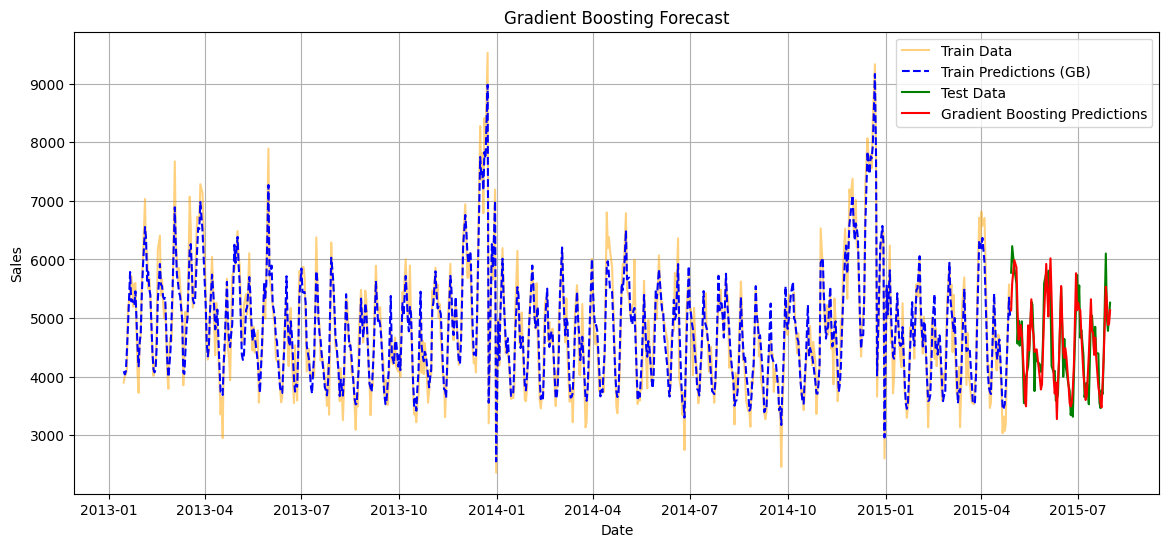

In [70]:
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(x_train, y_train)
gbr_pred = gbr.predict(x_valid)
gbr_metrics = evaluate_model(y_valid, gbr_pred, "Gradient Boosting Regressor")

train_predictions_gb = gbr.predict(x_train)

plt.figure(figsize=(14, 6))
plt.plot(train_data['Date'], y_train, label='Train Data', color='orange', alpha=0.5)
plt.plot(train_data['Date'], train_predictions_gb, label='Train Predictions (GB)', color='blue', linestyle='--')
plt.plot(valid_data['Date'], y_valid, label='Test Data', color='green')
plt.plot(valid_data['Date'], gbr_pred, label='Gradient Boosting Predictions', color='red')
plt.title('Gradient Boosting Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

### XGBoost

XGBoost Regressor Results:
MSE: 137669.94
RMSE: 371.04
MAE: 303.54
RMSPE: 0.0830


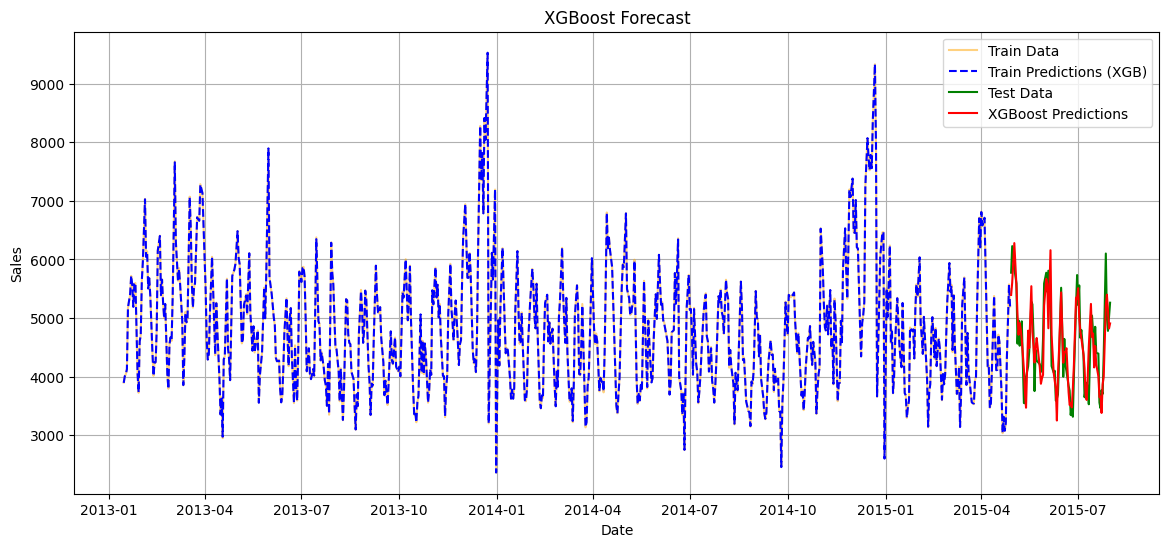

In [71]:
xgb = XGBRegressor(random_state=42)
xgb.fit(x_train, y_train)
xgb_pred = xgb.predict(x_valid)
xgb_metrics = evaluate_model(y_valid, xgb_pred, "XGBoost Regressor")

train_predictions_xgb = xgb.predict(x_train)

plt.figure(figsize=(14, 6))
plt.plot(train_data['Date'], y_train, label='Train Data', color='orange', alpha=0.5)
plt.plot(train_data['Date'], train_predictions_xgb, label='Train Predictions (XGB)', color='blue', linestyle='--')
plt.plot(valid_data['Date'], y_valid, label='Test Data', color='green')
plt.plot(valid_data['Date'], xgb_pred, label='XGBoost Predictions', color='red')
plt.title('XGBoost Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

### LightGBM

In [72]:
lgbm = LGBMRegressor(random_state=42)
lgbm.fit(x_train, y_train)
lgbm_pred = lgbm.predict(x_valid)
lgbm_metrics = evaluate_model(y_valid, lgbm_pred, "LightGBM Regressor")

train_predictions_lgbm = lgbm.predict(x_train)

plt.figure(figsize=(14, 6))
plt.plot(train_data['Date'], y_train, label='Train Data', color='orange', alpha=0.5)
plt.plot(train_data['Date'], train_predictions_lgbm, label='Train Predictions (LightGBM)', color='blue', linestyle='--')
plt.plot(valid_data['Date'], y_valid, label='Test Data', color='green')
plt.plot(valid_data['Date'], lgbm_pred, label='LightGBM Predictions', color='red')
plt.title('LightGBM Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1454
[LightGBM] [Info] Number of data points in the train set: 693, number of used features: 14
[LightGBM] [Info] Start training from score 4778.275613
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

### Cat Boosting

Learning rate set to 0.038638
0:	learn: 1016.3501506	total: 120ms	remaining: 2m
1:	learn: 1001.9991787	total: 124ms	remaining: 1m 1s
2:	learn: 983.7181293	total: 127ms	remaining: 42.1s
3:	learn: 967.0628508	total: 129ms	remaining: 32s
4:	learn: 949.9170636	total: 131ms	remaining: 26s
5:	learn: 933.7214827	total: 133ms	remaining: 22s
6:	learn: 918.7434365	total: 135ms	remaining: 19.1s
7:	learn: 904.4815519	total: 138ms	remaining: 17.1s
8:	learn: 892.1506013	total: 141ms	remaining: 15.5s
9:	learn: 877.5606886	total: 143ms	remaining: 14.1s
10:	learn: 862.9177883	total: 145ms	remaining: 13s
11:	learn: 849.8957019	total: 148ms	remaining: 12.2s
12:	learn: 837.9883370	total: 150ms	remaining: 11.4s
13:	learn: 828.5041363	total: 154ms	remaining: 10.8s
14:	learn: 816.9206805	total: 157ms	remaining: 10.3s
15:	learn: 805.5539087	total: 159ms	remaining: 9.75s
16:	learn: 796.0566913	total: 161ms	remaining: 9.29s
17:	learn: 784.8287353	total: 163ms	remaining: 8.87s
18:	learn: 774.6032971	total: 164ms

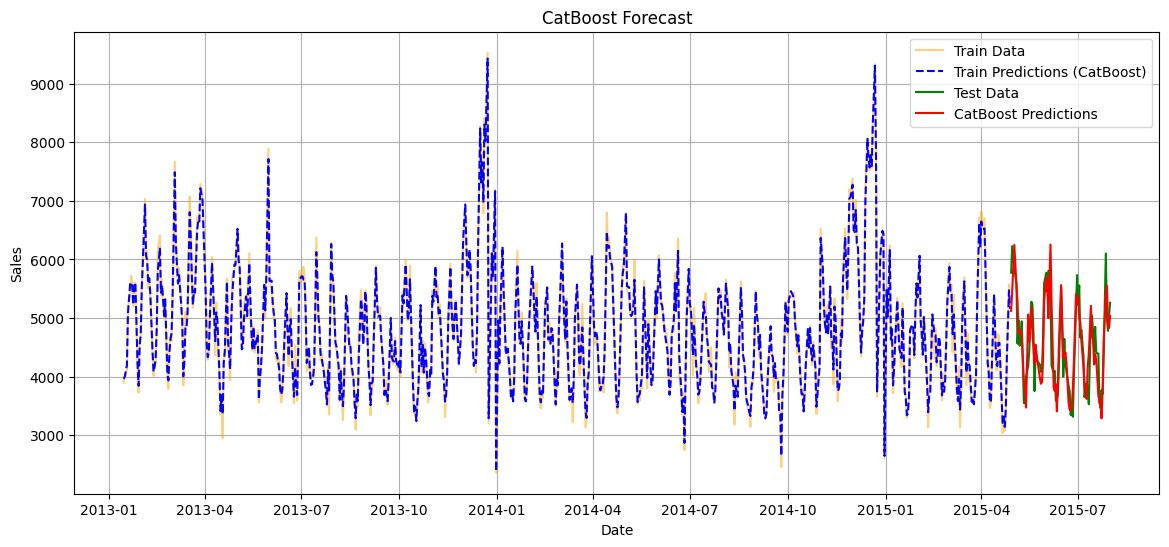

In [73]:
cbr = CatBoostRegressor(random_state=42)
cbr.fit(x_train, y_train)
cbr_pred = cbr.predict(x_valid)
cbr_metrics = evaluate_model(y_valid, cbr_pred, "CatBoost Regressor")

train_predictions_cbr = cbr.predict(x_train)

plt.figure(figsize=(14, 6))
plt.plot(train_data['Date'], y_train, label='Train Data', color='orange', alpha=0.5)
plt.plot(train_data['Date'], train_predictions_cbr, label='Train Predictions (CatBoost)', color='blue', linestyle='--')
plt.plot(valid_data['Date'], y_valid, label='Test Data', color='green')
plt.plot(valid_data['Date'], cbr_pred, label='CatBoost Predictions', color='red')
plt.title('CatBoost Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

### Compare All Model

In [74]:
model_scores = {
    "Moving Average": metrics_dict[window],
    "SES": ses_metrics,
    "Holt's Linear": holt_metrics,
    "Holt-Winters Additive": hw_metrics,
    "ARIMA": arima_metrics.loc[arima_metrics['Model'] == 'ARIMA(1, 1, 1)'].iloc[0, 1:].values,
    "SARIMAX": arima_metrics.loc[arima_metrics['Model'] == 'SARIMA(1, 1, 1)x(1, 1, 1, 7)'].iloc[0, 1:].values,
    "Prophet": prophet_metrics,
    "Gradient Boosting Regressor": gbr_metrics,
    "XGBoost Regressor": xgb_metrics,
    "CatBoost Regressor": cbr_metrics,
    "LightGBM Regressor": lgbm_metrics
}

scores_df = pd.DataFrame(model_scores).T
scores_df.columns = ['MSE', 'RMSE', 'MAE', 'RMSPE']
scores_df = scores_df.sort_values(by='RMSPE')
scores_df


MSE         RMSE         MAE     RMSPE
XGBoost Regressor             137669.944106   371.039006  303.536945  0.082984
Gradient Boosting Regressor   135315.041135   367.851928  284.684401  0.083274
LightGBM Regressor            130132.627551   360.739002   285.42614  0.083647
CatBoost Regressor            153797.081467    392.16971  314.446384  0.087267
SARIMAX                       569783.579835   754.840102   634.11617  0.157591
SES                           590351.540981   768.343374  638.735125  0.158086
Prophet                       497847.071252   705.582788  608.886162  0.164982
Moving Average                576431.135577   759.230621  647.213768  0.169995
Holt's Linear                 932627.645726   965.726486  748.151304  0.189432
Holt-Winters Additive        1012453.443224  1006.207455  779.715767  0.195972
ARIMA                         632057.211183   795.020258   664.40824   0.20508

In [75]:
plt.figure(figsize=(12, 6))
scores_df['RMSPE'].plot(kind='bar')
plt.title('RMSPE Comparison of All Models (The Lower, The Better)')
plt.axhline(y=scores_df['RMSPE'].min(), color='black', linestyle='--', label='Best RMSPE')
plt.ylabel('RMSPE')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.legend()
plt.show()